# Worm Simulation on 2D Ising Lattice

## Imports

In [383]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sys
import os
#from operator import xor
#from blocks import Blocks
from worm_simulation import WormSimulation
from bonds import Bonds
from specific_heat import SpecificHeat
from pca import PrincipalComponent
#from iterated_blocking import *
#from count_bonds import *
from specific_heat import SpecificHeat
from count_bonds import *
import matplotlib.image as mpimg
from matplotlib.offsetbox import AnchoredText
import matplotlib.offsetbox as offsetbox


%matplotlib notebook
import matplotlib as mpl
label_size = 14
plt.rc('font', family='serif')
plt.rc('text', usetex=True)
mpl.rcParams['xtick.labelsize'] = label_size 
mpl.rcParams['ytick.labelsize'] = label_size 

Tc =  2./np.log(1+np.sqrt(2))

## Generate Data

In [452]:
#for i in range(10):
print("\n" + 80*"*" + "\n")
print("Run #: {}".format(i))
print("\n" + 80*"*" + "\n")
bonds32 = Bonds(32, run=True, num_steps=1E8, T_start=1.8, T_end=2.8, T_step=0.05)
bonds16 = Bonds(16, run=True, num_steps=1E8, T_start=1.8, T_end=2.8, T_step=0.05)
bonds8 = Bonds(8, run=True, num_steps=1E8, T_start=1.8, T_end=2.8, T_step=0.05)
bonds4 = Bonds(4, run=True, num_steps=1E8, T_start=1.8, T_end=2.8, T_step=0.05)
bonds4 = Bonds(4, run=True, num_steps=1E8)
bonds8 = Bonds(8, run=True, num_steps=1E8)
bonds16 = Bonds(16, run=True, num_steps=1E8)
bonds32 = Bonds(32, run=True, num_steps=1E7)

Bonds(32, run=True, num_steps=1E8, decay_steps=False, T_start=1.8, T_end=2.8, T_step=0.05)
Bonds(16, run=True, num_steps=1E8, decay_steps=False, T_start=1.8, T_end=2.8, T_step=0.05)
Bonds(8, run=True, num_steps=1E8, decay_steps=False, T_start=1.8, T_end=2.8, T_step=0.05)
Bonds(4, run=True, num_steps=1E8, decay_steps=False, T_start=1.8, T_end=2.8, T_step=0.05)
Bonds(32, run=True, num_steps=1E8, decay_steps=False, T_start=1., T_end=4., T_step=0.1)
Bonds(16, run=True, num_steps=1E8, decay_steps=False, T_start=1., T_end=4., T_step=0.1)
Bonds(8, run=True, num_steps=1E8, decay_steps=False, T_start=1., T_end=4., T_step=0.1)
Bonds(4, run=True, num_steps=1E8, decay_steps=False, T_start=1., T_end=4., T_step=0.1)


********************************************************************************

Run #: 0

********************************************************************************

compilation -- start

compilation -- done

runs -- start

Running T = 1.8, num_steps: 100000000.0
Running T = 1.85, num_steps: 95263157.89473684
Running T = 1.9, num_steps: 90526315.78947368
Running T = 1.95, num_steps: 85789473.68421052
Running T = 2.0, num_steps: 81052631.57894737
Running T = 2.05, num_steps: 76315789.4736842
Running T = 2.1, num_steps: 71578947.36842105
Running T = 2.15, num_steps: 66842105.2631579
Running T = 2.2, num_steps: 62105263.15789474
Running T = 2.25, num_steps: 57368421.05263158
Running T = 2.3, num_steps: 52631578.94736842
Running T = 2.35, num_steps: 47894736.84210526
Running T = 2.4, num_steps: 43157894.73684211
Running T = 2.45, num_steps: 38421052.63157895
Running T = 2.5, num_steps: 33684210.52631579
Running T = 2.55, num_steps: 28947368.421052635
Running T = 2.6, num_steps: 24

Saving blocked configs to: ../data/blocked_configs/4_lattice/double_bonds_0/4_config_2.5.txt
Saving blocked configs to: ../data/blocked_configs/4_lattice/double_bonds_0/4_config_1.4.txt
Saving blocked configs to: ../data/blocked_configs/4_lattice/double_bonds_0/4_config_3.1.txt
Saving blocked configs to: ../data/blocked_configs/4_lattice/double_bonds_0/4_config_1.0.txt
Saving blocked configs to: ../data/blocked_configs/4_lattice/double_bonds_0/4_config_2.1.txt
Saving blocked configs to: ../data/blocked_configs/4_lattice/double_bonds_0/4_config_2.3.txt
Saving blocked configs to: ../data/blocked_configs/4_lattice/double_bonds_0/4_config_1.2.txt
Saving blocked configs to: ../data/blocked_configs/4_lattice/double_bonds_0/4_config_2.4.txt
Saving blocked configs to: ../data/blocked_configs/4_lattice/double_bonds_0/4_config_1.5.txt
Saving blocked configs to: ../data/blocked_configs/4_lattice/double_bonds_0/4_config_3.0.txt
Saving blocked configs to: ../data/blocked_configs/4_lattice/double_bo

Saving configs to: ../data/configs/16_lattice/separated_data/16_config_1.8.txt
Saving configs to: ../data/configs/16_lattice/separated_data/16_config_3.3.txt
Saving configs to: ../data/configs/16_lattice/separated_data/16_config_1.6.txt
Saving configs to: ../data/configs/16_lattice/separated_data/16_config_2.7.txt
Saving configs to: ../data/configs/16_lattice/separated_data/16_config_2.5.txt
Saving configs to: ../data/configs/16_lattice/separated_data/16_config_1.4.txt
Saving configs to: ../data/configs/16_lattice/separated_data/16_config_3.1.txt
Saving configs to: ../data/configs/16_lattice/separated_data/16_config_1.0.txt
Saving configs to: ../data/configs/16_lattice/separated_data/16_config_2.1.txt
Saving configs to: ../data/configs/16_lattice/separated_data/16_config_2.3.txt
Saving configs to: ../data/configs/16_lattice/separated_data/16_config_1.2.txt
Saving configs to: ../data/configs/16_lattice/separated_data/16_config_2.4.txt
Saving configs to: ../data/configs/16_lattice/separa

Saving blocked configs to: ../data/blocked_configs/32_lattice/double_bonds_0/32_config_1.5.txt
Saving blocked configs to: ../data/blocked_configs/32_lattice/double_bonds_0/32_config_3.0.txt
Saving blocked configs to: ../data/blocked_configs/32_lattice/double_bonds_0/32_config_3.2.txt
Saving blocked configs to: ../data/blocked_configs/32_lattice/double_bonds_0/32_config_1.7.txt
Saving blocked configs to: ../data/blocked_configs/32_lattice/double_bonds_0/32_config_2.6.txt
Saving blocked configs to: ../data/blocked_configs/32_lattice/double_bonds_0/32_config_2.2.txt
Saving blocked configs to: ../data/blocked_configs/32_lattice/double_bonds_0/32_config_1.3.txt
Saving blocked configs to: ../data/blocked_configs/32_lattice/double_bonds_0/32_config_3.4.txt
Saving blocked configs to: ../data/blocked_configs/32_lattice/double_bonds_0/32_config_1.1.txt
Saving blocked configs to: ../data/blocked_configs/32_lattice/double_bonds_0/32_config_2.0.txt

*************************************************

Saving configs to: ../data/configs/4_lattice/separated_data/4_config_1.3.txt
Saving configs to: ../data/configs/4_lattice/separated_data/4_config_3.4.txt
Saving configs to: ../data/configs/4_lattice/separated_data/4_config_1.1.txt
Saving configs to: ../data/configs/4_lattice/separated_data/4_config_2.0.txt
Saving blocked configs to: ../data/blocked_configs/4_lattice/double_bonds_0/4_config_2.8.txt
Saving blocked configs to: ../data/blocked_configs/4_lattice/double_bonds_0/4_config_1.9.txt
Saving blocked configs to: ../data/blocked_configs/4_lattice/double_bonds_0/4_config_2.9.txt
Saving blocked configs to: ../data/blocked_configs/4_lattice/double_bonds_0/4_config_1.8.txt
Saving blocked configs to: ../data/blocked_configs/4_lattice/double_bonds_0/4_config_3.3.txt
Saving blocked configs to: ../data/blocked_configs/4_lattice/double_bonds_0/4_config_1.6.txt
Saving blocked configs to: ../data/blocked_configs/4_lattice/double_bonds_0/4_config_2.7.txt
Saving blocked configs to: ../data/blocke

Running T = 1.6, num_steps: 77500000.0
Running T = 1.7, num_steps: 73750000.0
Running T = 1.8, num_steps: 70000000.0
Running T = 1.9, num_steps: 66250000.0
Running T = 2.0, num_steps: 62500000.0
Running T = 2.1, num_steps: 58750000.0
Running T = 2.2, num_steps: 55000000.0
Running T = 2.3, num_steps: 51250000.0
Running T = 2.4, num_steps: 47500000.0
Running T = 2.5, num_steps: 43750000.0
Running T = 2.6, num_steps: 40000000.0
Running T = 2.7, num_steps: 36250000.0
Running T = 2.8, num_steps: 32500000.0
Running T = 2.9, num_steps: 28750000.0
Running T = 3.0, num_steps: 25000000.0
Running T = 3.1, num_steps: 21250000.0
Running T = 3.2, num_steps: 17500000.0
Running T = 3.3, num_steps: 13750000.0
Running T = 3.4, num_steps: 10000000.0
Saving configs to: ../data/configs/16_lattice/separated_data/16_config_2.8.txt
Saving configs to: ../data/configs/16_lattice/separated_data/16_config_1.9.txt
Saving configs to: ../data/configs/16_lattice/separated_data/16_config_2.9.txt
Saving configs to: ../

Saving blocked configs to: ../data/blocked_configs/32_lattice/double_bonds_0/32_config_1.8.txt
Saving blocked configs to: ../data/blocked_configs/32_lattice/double_bonds_0/32_config_3.3.txt
Saving blocked configs to: ../data/blocked_configs/32_lattice/double_bonds_0/32_config_1.6.txt
Saving blocked configs to: ../data/blocked_configs/32_lattice/double_bonds_0/32_config_2.7.txt
Saving blocked configs to: ../data/blocked_configs/32_lattice/double_bonds_0/32_config_2.5.txt
Saving blocked configs to: ../data/blocked_configs/32_lattice/double_bonds_0/32_config_1.4.txt
Saving blocked configs to: ../data/blocked_configs/32_lattice/double_bonds_0/32_config_3.1.txt
Saving blocked configs to: ../data/blocked_configs/32_lattice/double_bonds_0/32_config_1.0.txt
Saving blocked configs to: ../data/blocked_configs/32_lattice/double_bonds_0/32_config_2.1.txt
Saving blocked configs to: ../data/blocked_configs/32_lattice/double_bonds_0/32_config_2.3.txt
Saving blocked configs to: ../data/blocked_configs

Saving configs to: ../data/configs/4_lattice/separated_data/4_config_2.7.txt
Saving configs to: ../data/configs/4_lattice/separated_data/4_config_2.5.txt
Saving configs to: ../data/configs/4_lattice/separated_data/4_config_1.4.txt
Saving configs to: ../data/configs/4_lattice/separated_data/4_config_3.1.txt
Saving configs to: ../data/configs/4_lattice/separated_data/4_config_1.0.txt
Saving configs to: ../data/configs/4_lattice/separated_data/4_config_2.1.txt
Saving configs to: ../data/configs/4_lattice/separated_data/4_config_2.3.txt
Saving configs to: ../data/configs/4_lattice/separated_data/4_config_1.2.txt
Saving configs to: ../data/configs/4_lattice/separated_data/4_config_2.4.txt
Saving configs to: ../data/configs/4_lattice/separated_data/4_config_1.5.txt
Saving configs to: ../data/configs/4_lattice/separated_data/4_config_3.0.txt
Saving configs to: ../data/configs/4_lattice/separated_data/4_config_3.2.txt
Saving configs to: ../data/configs/4_lattice/separated_data/4_config_1.7.txt

Saving blocked configs to: ../data/blocked_configs/8_lattice/double_bonds_0/8_config_3.0.txt
Saving blocked configs to: ../data/blocked_configs/8_lattice/double_bonds_0/8_config_3.2.txt
Saving blocked configs to: ../data/blocked_configs/8_lattice/double_bonds_0/8_config_1.7.txt
Saving blocked configs to: ../data/blocked_configs/8_lattice/double_bonds_0/8_config_2.6.txt
Saving blocked configs to: ../data/blocked_configs/8_lattice/double_bonds_0/8_config_2.2.txt
Saving blocked configs to: ../data/blocked_configs/8_lattice/double_bonds_0/8_config_1.3.txt
Saving blocked configs to: ../data/blocked_configs/8_lattice/double_bonds_0/8_config_3.4.txt
Saving blocked configs to: ../data/blocked_configs/8_lattice/double_bonds_0/8_config_1.1.txt
Saving blocked configs to: ../data/blocked_configs/8_lattice/double_bonds_0/8_config_2.0.txt
compilation -- start

compilation -- done

runs -- start

Running T = 1.0, num_steps: 100000000.0
Running T = 1.1, num_steps: 96250000.0
Running T = 1.2, num_steps

Saving configs to: ../data/configs/32_lattice/separated_data/32_config_1.2.txt
Saving configs to: ../data/configs/32_lattice/separated_data/32_config_2.4.txt
Saving configs to: ../data/configs/32_lattice/separated_data/32_config_1.5.txt
Saving configs to: ../data/configs/32_lattice/separated_data/32_config_3.0.txt
Saving configs to: ../data/configs/32_lattice/separated_data/32_config_3.2.txt
Saving configs to: ../data/configs/32_lattice/separated_data/32_config_1.7.txt
Saving configs to: ../data/configs/32_lattice/separated_data/32_config_2.6.txt
Saving configs to: ../data/configs/32_lattice/separated_data/32_config_2.2.txt
Saving configs to: ../data/configs/32_lattice/separated_data/32_config_1.3.txt
Saving configs to: ../data/configs/32_lattice/separated_data/32_config_3.4.txt
Saving configs to: ../data/configs/32_lattice/separated_data/32_config_1.1.txt
Saving configs to: ../data/configs/32_lattice/separated_data/32_config_2.0.txt
Saving blocked configs to: ../data/blocked_configs/3

Running T = 1.5, num_steps: 81250000.0
Running T = 1.6, num_steps: 77500000.0
Running T = 1.7, num_steps: 73750000.0
Running T = 1.8, num_steps: 70000000.0
Running T = 1.9, num_steps: 66250000.0
Running T = 2.0, num_steps: 62500000.0
Running T = 2.1, num_steps: 58750000.0
Running T = 2.2, num_steps: 55000000.0
Running T = 2.3, num_steps: 51250000.0
Running T = 2.4, num_steps: 47500000.0
Running T = 2.5, num_steps: 43750000.0
Running T = 2.6, num_steps: 40000000.0
Running T = 2.7, num_steps: 36250000.0
Running T = 2.8, num_steps: 32500000.0
Running T = 2.9, num_steps: 28750000.0
Running T = 3.0, num_steps: 25000000.0
Running T = 3.1, num_steps: 21250000.0
Running T = 3.2, num_steps: 17500000.0
Running T = 3.3, num_steps: 13750000.0
Running T = 3.4, num_steps: 10000000.0
Saving configs to: ../data/configs/4_lattice/separated_data/4_config_2.8.txt
Saving configs to: ../data/configs/4_lattice/separated_data/4_config_1.9.txt
Saving configs to: ../data/configs/4_lattice/separated_data/4_conf

Saving blocked configs to: ../data/blocked_configs/8_lattice/double_bonds_0/8_config_1.8.txt
Saving blocked configs to: ../data/blocked_configs/8_lattice/double_bonds_0/8_config_3.3.txt
Saving blocked configs to: ../data/blocked_configs/8_lattice/double_bonds_0/8_config_1.6.txt
Saving blocked configs to: ../data/blocked_configs/8_lattice/double_bonds_0/8_config_2.7.txt
Saving blocked configs to: ../data/blocked_configs/8_lattice/double_bonds_0/8_config_2.5.txt
Saving blocked configs to: ../data/blocked_configs/8_lattice/double_bonds_0/8_config_1.4.txt
Saving blocked configs to: ../data/blocked_configs/8_lattice/double_bonds_0/8_config_3.1.txt
Saving blocked configs to: ../data/blocked_configs/8_lattice/double_bonds_0/8_config_1.0.txt
Saving blocked configs to: ../data/blocked_configs/8_lattice/double_bonds_0/8_config_2.1.txt
Saving blocked configs to: ../data/blocked_configs/8_lattice/double_bonds_0/8_config_2.3.txt
Saving blocked configs to: ../data/blocked_configs/8_lattice/double_bo

Running T = 2.9, num_steps: 2875000.0
Running T = 3.0, num_steps: 2500000.0
Running T = 3.1, num_steps: 2125000.0
Running T = 3.2, num_steps: 1750000.0
Running T = 3.3, num_steps: 1375000.0
Running T = 3.4, num_steps: 1000000.0
Saving configs to: ../data/configs/32_lattice/separated_data/32_config_2.8.txt
Saving configs to: ../data/configs/32_lattice/separated_data/32_config_1.9.txt
Saving configs to: ../data/configs/32_lattice/separated_data/32_config_2.9.txt
Saving configs to: ../data/configs/32_lattice/separated_data/32_config_1.8.txt
Saving configs to: ../data/configs/32_lattice/separated_data/32_config_3.3.txt
Saving configs to: ../data/configs/32_lattice/separated_data/32_config_1.6.txt
Saving configs to: ../data/configs/32_lattice/separated_data/32_config_2.7.txt
Saving configs to: ../data/configs/32_lattice/separated_data/32_config_2.5.txt
Saving configs to: ../data/configs/32_lattice/separated_data/32_config_1.4.txt
Saving configs to: ../data/configs/32_lattice/separated_data/

Saving blocked configs to: ../data/blocked_configs/32_lattice/double_bonds_0/32_config_2.7.txt
Saving blocked configs to: ../data/blocked_configs/32_lattice/double_bonds_0/32_config_2.5.txt
Saving blocked configs to: ../data/blocked_configs/32_lattice/double_bonds_0/32_config_1.95.txt
Saving blocked configs to: ../data/blocked_configs/32_lattice/double_bonds_0/32_config_2.1.txt
Saving blocked configs to: ../data/blocked_configs/32_lattice/double_bonds_0/32_config_2.3.txt
Saving blocked configs to: ../data/blocked_configs/32_lattice/double_bonds_0/32_config_2.4.txt
Saving blocked configs to: ../data/blocked_configs/32_lattice/double_bonds_0/32_config_1.85.txt
Saving blocked configs to: ../data/blocked_configs/32_lattice/double_bonds_0/32_config_2.6.txt
Saving blocked configs to: ../data/blocked_configs/32_lattice/double_bonds_0/32_config_2.2.txt
Saving blocked configs to: ../data/blocked_configs/32_lattice/double_bonds_0/32_config_2.0.txt
compilation -- start

compilation -- done

runs 

Saving configs to: ../data/configs/8_lattice/separated_data/8_config_2.3.txt
Saving configs to: ../data/configs/8_lattice/separated_data/8_config_1.2.txt
Saving configs to: ../data/configs/8_lattice/separated_data/8_config_2.4.txt
Saving configs to: ../data/configs/8_lattice/separated_data/8_config_1.5.txt
Saving configs to: ../data/configs/8_lattice/separated_data/8_config_3.0.txt
Saving configs to: ../data/configs/8_lattice/separated_data/8_config_3.2.txt
Saving configs to: ../data/configs/8_lattice/separated_data/8_config_1.7.txt
Saving configs to: ../data/configs/8_lattice/separated_data/8_config_2.6.txt
Saving configs to: ../data/configs/8_lattice/separated_data/8_config_2.2.txt
Saving configs to: ../data/configs/8_lattice/separated_data/8_config_1.3.txt
Saving configs to: ../data/configs/8_lattice/separated_data/8_config_3.4.txt
Saving configs to: ../data/configs/8_lattice/separated_data/8_config_1.1.txt
Saving configs to: ../data/configs/8_lattice/separated_data/8_config_2.0.txt

Saving blocked configs to: ../data/blocked_configs/16_lattice/double_bonds_0/16_config_2.2.txt
Saving blocked configs to: ../data/blocked_configs/16_lattice/double_bonds_0/16_config_1.3.txt
Saving blocked configs to: ../data/blocked_configs/16_lattice/double_bonds_0/16_config_3.4.txt
Saving blocked configs to: ../data/blocked_configs/16_lattice/double_bonds_0/16_config_1.1.txt
Saving blocked configs to: ../data/blocked_configs/16_lattice/double_bonds_0/16_config_2.0.txt
compilation -- start

compilation -- done

runs -- start

Running T = 1.0, num_steps: 10000000.0
Running T = 1.1, num_steps: 9625000.0
Running T = 1.2, num_steps: 9250000.0
Running T = 1.3, num_steps: 8875000.0
Running T = 1.4, num_steps: 8500000.0
Running T = 1.5, num_steps: 8125000.0
Running T = 1.6, num_steps: 7750000.0
Running T = 1.7, num_steps: 7375000.0
Running T = 1.8, num_steps: 7000000.0
Running T = 1.9, num_steps: 6625000.0
Running T = 2.0, num_steps: 6250000.0
Running T = 2.1, num_steps: 5875000.0
Running T 

Saving configs to: ../data/configs/32_lattice/separated_data/32_config_1.85.txt
Saving configs to: ../data/configs/32_lattice/separated_data/32_config_2.6.txt
Saving configs to: ../data/configs/32_lattice/separated_data/32_config_2.2.txt
Saving configs to: ../data/configs/32_lattice/separated_data/32_config_2.0.txt
Saving blocked configs to: ../data/blocked_configs/32_lattice/double_bonds_0/32_config_2.15.txt
Saving blocked configs to: ../data/blocked_configs/32_lattice/double_bonds_0/32_config_2.35.txt
Saving blocked configs to: ../data/blocked_configs/32_lattice/double_bonds_0/32_config_2.75.txt
Saving blocked configs to: ../data/blocked_configs/32_lattice/double_bonds_0/32_config_2.55.txt
Saving blocked configs to: ../data/blocked_configs/32_lattice/double_bonds_0/32_config_1.9.txt
Saving blocked configs to: ../data/blocked_configs/32_lattice/double_bonds_0/32_config_2.25.txt
Saving blocked configs to: ../data/blocked_configs/32_lattice/double_bonds_0/32_config_2.05.txt
Saving block

Running T = 2.6, num_steps: 40000000.0
Running T = 2.7, num_steps: 36250000.0
Running T = 2.8, num_steps: 32500000.0
Running T = 2.9, num_steps: 28750000.0
Running T = 3.0, num_steps: 25000000.0
Running T = 3.1, num_steps: 21250000.0
Running T = 3.2, num_steps: 17500000.0
Running T = 3.3, num_steps: 13750000.0
Running T = 3.4, num_steps: 10000000.0
Saving configs to: ../data/configs/8_lattice/separated_data/8_config_2.8.txt
Saving configs to: ../data/configs/8_lattice/separated_data/8_config_1.9.txt
Saving configs to: ../data/configs/8_lattice/separated_data/8_config_2.9.txt
Saving configs to: ../data/configs/8_lattice/separated_data/8_config_1.8.txt
Saving configs to: ../data/configs/8_lattice/separated_data/8_config_3.3.txt
Saving configs to: ../data/configs/8_lattice/separated_data/8_config_1.6.txt
Saving configs to: ../data/configs/8_lattice/separated_data/8_config_2.7.txt
Saving configs to: ../data/configs/8_lattice/separated_data/8_config_2.5.txt
Saving configs to: ../data/config

Saving blocked configs to: ../data/blocked_configs/16_lattice/double_bonds_0/16_config_2.5.txt
Saving blocked configs to: ../data/blocked_configs/16_lattice/double_bonds_0/16_config_1.4.txt
Saving blocked configs to: ../data/blocked_configs/16_lattice/double_bonds_0/16_config_3.1.txt
Saving blocked configs to: ../data/blocked_configs/16_lattice/double_bonds_0/16_config_1.0.txt
Saving blocked configs to: ../data/blocked_configs/16_lattice/double_bonds_0/16_config_2.1.txt
Saving blocked configs to: ../data/blocked_configs/16_lattice/double_bonds_0/16_config_2.3.txt
Saving blocked configs to: ../data/blocked_configs/16_lattice/double_bonds_0/16_config_1.2.txt
Saving blocked configs to: ../data/blocked_configs/16_lattice/double_bonds_0/16_config_2.4.txt
Saving blocked configs to: ../data/blocked_configs/16_lattice/double_bonds_0/16_config_1.5.txt
Saving blocked configs to: ../data/blocked_configs/16_lattice/double_bonds_0/16_config_3.0.txt
Saving blocked configs to: ../data/blocked_configs

Saving configs to: ../data/configs/32_lattice/separated_data/32_config_2.15.txt
Saving configs to: ../data/configs/32_lattice/separated_data/32_config_2.35.txt
Saving configs to: ../data/configs/32_lattice/separated_data/32_config_2.75.txt
Saving configs to: ../data/configs/32_lattice/separated_data/32_config_2.55.txt
Saving configs to: ../data/configs/32_lattice/separated_data/32_config_1.9.txt
Saving configs to: ../data/configs/32_lattice/separated_data/32_config_2.25.txt
Saving configs to: ../data/configs/32_lattice/separated_data/32_config_2.05.txt
Saving configs to: ../data/configs/32_lattice/separated_data/32_config_2.45.txt
Saving configs to: ../data/configs/32_lattice/separated_data/32_config_1.8.txt
Saving configs to: ../data/configs/32_lattice/separated_data/32_config_2.65.txt
Saving configs to: ../data/configs/32_lattice/separated_data/32_config_2.7.txt
Saving configs to: ../data/configs/32_lattice/separated_data/32_config_2.5.txt
Saving configs to: ../data/configs/32_lattic

Saving blocked configs to: ../data/blocked_configs/4_lattice/double_bonds_0/4_config_2.6.txt
Saving blocked configs to: ../data/blocked_configs/4_lattice/double_bonds_0/4_config_2.2.txt
Saving blocked configs to: ../data/blocked_configs/4_lattice/double_bonds_0/4_config_1.3.txt
Saving blocked configs to: ../data/blocked_configs/4_lattice/double_bonds_0/4_config_3.4.txt
Saving blocked configs to: ../data/blocked_configs/4_lattice/double_bonds_0/4_config_1.1.txt
Saving blocked configs to: ../data/blocked_configs/4_lattice/double_bonds_0/4_config_2.0.txt
compilation -- start

compilation -- done

runs -- start

Running T = 1.0, num_steps: 100000000.0
Running T = 1.1, num_steps: 96250000.0
Running T = 1.2, num_steps: 92500000.0
Running T = 1.3, num_steps: 88750000.0
Running T = 1.4, num_steps: 85000000.0
Running T = 1.5, num_steps: 81250000.0
Running T = 1.6, num_steps: 77500000.0
Running T = 1.7, num_steps: 73750000.0
Running T = 1.8, num_steps: 70000000.0
Running T = 1.9, num_steps: 6625

Saving configs to: ../data/configs/16_lattice/separated_data/16_config_3.2.txt
Saving configs to: ../data/configs/16_lattice/separated_data/16_config_1.7.txt
Saving configs to: ../data/configs/16_lattice/separated_data/16_config_2.6.txt
Saving configs to: ../data/configs/16_lattice/separated_data/16_config_2.2.txt
Saving configs to: ../data/configs/16_lattice/separated_data/16_config_1.3.txt
Saving configs to: ../data/configs/16_lattice/separated_data/16_config_3.4.txt
Saving configs to: ../data/configs/16_lattice/separated_data/16_config_1.1.txt
Saving configs to: ../data/configs/16_lattice/separated_data/16_config_2.0.txt
Saving blocked configs to: ../data/blocked_configs/16_lattice/double_bonds_0/16_config_2.8.txt
Saving blocked configs to: ../data/blocked_configs/16_lattice/double_bonds_0/16_config_1.9.txt
Saving blocked configs to: ../data/blocked_configs/16_lattice/double_bonds_0/16_config_2.9.txt
Saving blocked configs to: ../data/blocked_configs/16_lattice/double_bonds_0/16_con


********************************************************************************

Run #: 7

********************************************************************************

compilation -- start

compilation -- done

runs -- start

Running T = 1.8, num_steps: 100000000.0
Running T = 1.85, num_steps: 95263157.89473684
Running T = 1.9, num_steps: 90526315.78947368
Running T = 1.95, num_steps: 85789473.68421052
Running T = 2.0, num_steps: 81052631.57894737
Running T = 2.05, num_steps: 76315789.4736842
Running T = 2.1, num_steps: 71578947.36842105
Running T = 2.15, num_steps: 66842105.2631579
Running T = 2.2, num_steps: 62105263.15789474
Running T = 2.25, num_steps: 57368421.05263158
Running T = 2.3, num_steps: 52631578.94736842
Running T = 2.35, num_steps: 47894736.84210526
Running T = 2.4, num_steps: 43157894.73684211
Running T = 2.45, num_steps: 38421052.63157895
Running T = 2.5, num_steps: 33684210.52631579
Running T = 2.55, num_steps: 28947368.421052635
Running T = 2.6, num_steps: 24

Saving blocked configs to: ../data/blocked_configs/4_lattice/double_bonds_0/4_config_2.5.txt
Saving blocked configs to: ../data/blocked_configs/4_lattice/double_bonds_0/4_config_1.4.txt
Saving blocked configs to: ../data/blocked_configs/4_lattice/double_bonds_0/4_config_3.1.txt
Saving blocked configs to: ../data/blocked_configs/4_lattice/double_bonds_0/4_config_1.0.txt
Saving blocked configs to: ../data/blocked_configs/4_lattice/double_bonds_0/4_config_2.1.txt
Saving blocked configs to: ../data/blocked_configs/4_lattice/double_bonds_0/4_config_2.3.txt
Saving blocked configs to: ../data/blocked_configs/4_lattice/double_bonds_0/4_config_1.2.txt
Saving blocked configs to: ../data/blocked_configs/4_lattice/double_bonds_0/4_config_2.4.txt
Saving blocked configs to: ../data/blocked_configs/4_lattice/double_bonds_0/4_config_1.5.txt
Saving blocked configs to: ../data/blocked_configs/4_lattice/double_bonds_0/4_config_3.0.txt
Saving blocked configs to: ../data/blocked_configs/4_lattice/double_bo

Saving configs to: ../data/configs/16_lattice/separated_data/16_config_1.8.txt
Saving configs to: ../data/configs/16_lattice/separated_data/16_config_3.3.txt
Saving configs to: ../data/configs/16_lattice/separated_data/16_config_1.6.txt
Saving configs to: ../data/configs/16_lattice/separated_data/16_config_2.7.txt
Saving configs to: ../data/configs/16_lattice/separated_data/16_config_2.5.txt
Saving configs to: ../data/configs/16_lattice/separated_data/16_config_1.4.txt
Saving configs to: ../data/configs/16_lattice/separated_data/16_config_3.1.txt
Saving configs to: ../data/configs/16_lattice/separated_data/16_config_1.0.txt
Saving configs to: ../data/configs/16_lattice/separated_data/16_config_2.1.txt
Saving configs to: ../data/configs/16_lattice/separated_data/16_config_2.3.txt
Saving configs to: ../data/configs/16_lattice/separated_data/16_config_1.2.txt
Saving configs to: ../data/configs/16_lattice/separated_data/16_config_2.4.txt
Saving configs to: ../data/configs/16_lattice/separa

Saving blocked configs to: ../data/blocked_configs/32_lattice/double_bonds_0/32_config_1.5.txt
Saving blocked configs to: ../data/blocked_configs/32_lattice/double_bonds_0/32_config_3.0.txt
Saving blocked configs to: ../data/blocked_configs/32_lattice/double_bonds_0/32_config_3.2.txt
Saving blocked configs to: ../data/blocked_configs/32_lattice/double_bonds_0/32_config_1.7.txt
Saving blocked configs to: ../data/blocked_configs/32_lattice/double_bonds_0/32_config_2.6.txt
Saving blocked configs to: ../data/blocked_configs/32_lattice/double_bonds_0/32_config_2.2.txt
Saving blocked configs to: ../data/blocked_configs/32_lattice/double_bonds_0/32_config_1.3.txt
Saving blocked configs to: ../data/blocked_configs/32_lattice/double_bonds_0/32_config_3.4.txt
Saving blocked configs to: ../data/blocked_configs/32_lattice/double_bonds_0/32_config_1.1.txt
Saving blocked configs to: ../data/blocked_configs/32_lattice/double_bonds_0/32_config_2.0.txt

*************************************************

Saving configs to: ../data/configs/4_lattice/separated_data/4_config_1.3.txt
Saving configs to: ../data/configs/4_lattice/separated_data/4_config_3.4.txt
Saving configs to: ../data/configs/4_lattice/separated_data/4_config_1.1.txt
Saving configs to: ../data/configs/4_lattice/separated_data/4_config_2.0.txt
Saving blocked configs to: ../data/blocked_configs/4_lattice/double_bonds_0/4_config_2.8.txt
Saving blocked configs to: ../data/blocked_configs/4_lattice/double_bonds_0/4_config_1.9.txt
Saving blocked configs to: ../data/blocked_configs/4_lattice/double_bonds_0/4_config_2.9.txt
Saving blocked configs to: ../data/blocked_configs/4_lattice/double_bonds_0/4_config_1.8.txt
Saving blocked configs to: ../data/blocked_configs/4_lattice/double_bonds_0/4_config_3.3.txt
Saving blocked configs to: ../data/blocked_configs/4_lattice/double_bonds_0/4_config_1.6.txt
Saving blocked configs to: ../data/blocked_configs/4_lattice/double_bonds_0/4_config_2.7.txt
Saving blocked configs to: ../data/blocke

Running T = 1.6, num_steps: 77500000.0
Running T = 1.7, num_steps: 73750000.0
Running T = 1.8, num_steps: 70000000.0
Running T = 1.9, num_steps: 66250000.0
Running T = 2.0, num_steps: 62500000.0
Running T = 2.1, num_steps: 58750000.0
Running T = 2.2, num_steps: 55000000.0
Running T = 2.3, num_steps: 51250000.0
Running T = 2.4, num_steps: 47500000.0
Running T = 2.5, num_steps: 43750000.0
Running T = 2.6, num_steps: 40000000.0
Running T = 2.7, num_steps: 36250000.0
Running T = 2.8, num_steps: 32500000.0
Running T = 2.9, num_steps: 28750000.0
Running T = 3.0, num_steps: 25000000.0
Running T = 3.1, num_steps: 21250000.0
Running T = 3.2, num_steps: 17500000.0
Running T = 3.3, num_steps: 13750000.0
Running T = 3.4, num_steps: 10000000.0
Saving configs to: ../data/configs/16_lattice/separated_data/16_config_2.8.txt
Saving configs to: ../data/configs/16_lattice/separated_data/16_config_1.9.txt
Saving configs to: ../data/configs/16_lattice/separated_data/16_config_2.9.txt
Saving configs to: ../

Saving blocked configs to: ../data/blocked_configs/32_lattice/double_bonds_0/32_config_1.8.txt
Saving blocked configs to: ../data/blocked_configs/32_lattice/double_bonds_0/32_config_3.3.txt
Saving blocked configs to: ../data/blocked_configs/32_lattice/double_bonds_0/32_config_1.6.txt
Saving blocked configs to: ../data/blocked_configs/32_lattice/double_bonds_0/32_config_2.7.txt
Saving blocked configs to: ../data/blocked_configs/32_lattice/double_bonds_0/32_config_2.5.txt
Saving blocked configs to: ../data/blocked_configs/32_lattice/double_bonds_0/32_config_1.4.txt
Saving blocked configs to: ../data/blocked_configs/32_lattice/double_bonds_0/32_config_3.1.txt
Saving blocked configs to: ../data/blocked_configs/32_lattice/double_bonds_0/32_config_1.0.txt
Saving blocked configs to: ../data/blocked_configs/32_lattice/double_bonds_0/32_config_2.1.txt
Saving blocked configs to: ../data/blocked_configs/32_lattice/double_bonds_0/32_config_2.3.txt
Saving blocked configs to: ../data/blocked_configs

Saving configs to: ../data/configs/4_lattice/separated_data/4_config_2.7.txt
Saving configs to: ../data/configs/4_lattice/separated_data/4_config_2.5.txt
Saving configs to: ../data/configs/4_lattice/separated_data/4_config_1.4.txt
Saving configs to: ../data/configs/4_lattice/separated_data/4_config_3.1.txt
Saving configs to: ../data/configs/4_lattice/separated_data/4_config_1.0.txt
Saving configs to: ../data/configs/4_lattice/separated_data/4_config_2.1.txt
Saving configs to: ../data/configs/4_lattice/separated_data/4_config_2.3.txt
Saving configs to: ../data/configs/4_lattice/separated_data/4_config_1.2.txt
Saving configs to: ../data/configs/4_lattice/separated_data/4_config_2.4.txt
Saving configs to: ../data/configs/4_lattice/separated_data/4_config_1.5.txt
Saving configs to: ../data/configs/4_lattice/separated_data/4_config_3.0.txt
Saving configs to: ../data/configs/4_lattice/separated_data/4_config_3.2.txt
Saving configs to: ../data/configs/4_lattice/separated_data/4_config_1.7.txt

Saving blocked configs to: ../data/blocked_configs/8_lattice/double_bonds_0/8_config_3.0.txt
Saving blocked configs to: ../data/blocked_configs/8_lattice/double_bonds_0/8_config_3.2.txt
Saving blocked configs to: ../data/blocked_configs/8_lattice/double_bonds_0/8_config_1.7.txt
Saving blocked configs to: ../data/blocked_configs/8_lattice/double_bonds_0/8_config_2.6.txt
Saving blocked configs to: ../data/blocked_configs/8_lattice/double_bonds_0/8_config_2.2.txt
Saving blocked configs to: ../data/blocked_configs/8_lattice/double_bonds_0/8_config_1.3.txt
Saving blocked configs to: ../data/blocked_configs/8_lattice/double_bonds_0/8_config_3.4.txt
Saving blocked configs to: ../data/blocked_configs/8_lattice/double_bonds_0/8_config_1.1.txt
Saving blocked configs to: ../data/blocked_configs/8_lattice/double_bonds_0/8_config_2.0.txt
compilation -- start

compilation -- done

runs -- start

Running T = 1.0, num_steps: 100000000.0
Running T = 1.1, num_steps: 96250000.0
Running T = 1.2, num_steps

Saving configs to: ../data/configs/32_lattice/separated_data/32_config_1.2.txt
Saving configs to: ../data/configs/32_lattice/separated_data/32_config_2.4.txt
Saving configs to: ../data/configs/32_lattice/separated_data/32_config_1.5.txt
Saving configs to: ../data/configs/32_lattice/separated_data/32_config_3.0.txt
Saving configs to: ../data/configs/32_lattice/separated_data/32_config_3.2.txt
Saving configs to: ../data/configs/32_lattice/separated_data/32_config_1.7.txt
Saving configs to: ../data/configs/32_lattice/separated_data/32_config_2.6.txt
Saving configs to: ../data/configs/32_lattice/separated_data/32_config_2.2.txt
Saving configs to: ../data/configs/32_lattice/separated_data/32_config_1.3.txt
Saving configs to: ../data/configs/32_lattice/separated_data/32_config_3.4.txt
Saving configs to: ../data/configs/32_lattice/separated_data/32_config_1.1.txt
Saving configs to: ../data/configs/32_lattice/separated_data/32_config_2.0.txt
Saving blocked configs to: ../data/blocked_configs/3

# Data Analysis

## $\langle N_b \rangle$, and $\langle \Delta_{N_b}^2\rangle$

In [590]:
bc32 = bond_counter(32, write=True)
bc32_b = bond_counter(32, blocked_val=0, write=True)

Reading from: ../data/configs/32_lattice/separated_data/32_config_1.0.txt

Reading from: ../data/configs/32_lattice/separated_data/32_config_1.1.txt

Reading from: ../data/configs/32_lattice/separated_data/32_config_1.2.txt

Reading from: ../data/configs/32_lattice/separated_data/32_config_1.3.txt

Reading from: ../data/configs/32_lattice/separated_data/32_config_1.4.txt

Reading from: ../data/configs/32_lattice/separated_data/32_config_1.5.txt

Reading from: ../data/configs/32_lattice/separated_data/32_config_1.6.txt

Reading from: ../data/configs/32_lattice/separated_data/32_config_1.7.txt

Reading from: ../data/configs/32_lattice/separated_data/32_config_1.8.txt

Reading from: ../data/configs/32_lattice/separated_data/32_config_1.85.txt

Reading from: ../data/configs/32_lattice/separated_data/32_config_1.9.txt

Reading from: ../data/configs/32_lattice/separated_data/32_config_1.95.txt

Reading from: ../data/configs/32_lattice/separated_data/32_config_2.0.txt

Reading from: ../data/c

In [591]:
bc16 = bond_counter(16, write=True)
bc16_b = bond_counter(16, blocked_val=0, write=True)

Reading from: ../data/configs/16_lattice/separated_data/16_config_1.0.txt

Reading from: ../data/configs/16_lattice/separated_data/16_config_1.1.txt

Reading from: ../data/configs/16_lattice/separated_data/16_config_1.2.txt

Reading from: ../data/configs/16_lattice/separated_data/16_config_1.3.txt

Reading from: ../data/configs/16_lattice/separated_data/16_config_1.4.txt

Reading from: ../data/configs/16_lattice/separated_data/16_config_1.5.txt

Reading from: ../data/configs/16_lattice/separated_data/16_config_1.6.txt

Reading from: ../data/configs/16_lattice/separated_data/16_config_1.7.txt

Reading from: ../data/configs/16_lattice/separated_data/16_config_1.8.txt

Reading from: ../data/configs/16_lattice/separated_data/16_config_1.85.txt

Reading from: ../data/configs/16_lattice/separated_data/16_config_1.9.txt

Reading from: ../data/configs/16_lattice/separated_data/16_config_1.95.txt

Reading from: ../data/configs/16_lattice/separated_data/16_config_2.0.txt

Reading from: ../data/c

In [592]:
bc8 = bond_counter(8, write=True)
bc8_b = bond_counter(8, blocked_val=0, write=True)

Reading from: ../data/configs/8_lattice/separated_data/8_config_1.0.txt

Reading from: ../data/configs/8_lattice/separated_data/8_config_1.1.txt

Reading from: ../data/configs/8_lattice/separated_data/8_config_1.2.txt

Reading from: ../data/configs/8_lattice/separated_data/8_config_1.3.txt

Reading from: ../data/configs/8_lattice/separated_data/8_config_1.4.txt

Reading from: ../data/configs/8_lattice/separated_data/8_config_1.5.txt

Reading from: ../data/configs/8_lattice/separated_data/8_config_1.6.txt

Reading from: ../data/configs/8_lattice/separated_data/8_config_1.7.txt

Reading from: ../data/configs/8_lattice/separated_data/8_config_1.8.txt

Reading from: ../data/configs/8_lattice/separated_data/8_config_1.85.txt

Reading from: ../data/configs/8_lattice/separated_data/8_config_1.9.txt

Reading from: ../data/configs/8_lattice/separated_data/8_config_1.95.txt

Reading from: ../data/configs/8_lattice/separated_data/8_config_2.0.txt

Reading from: ../data/configs/8_lattice/separated

In [593]:
bc4 = bond_counter(4, write=True)
bc4_b = bond_counter(4, blocked_val=0, write=True)

Reading from: ../data/configs/4_lattice/separated_data/4_config_1.0.txt

Reading from: ../data/configs/4_lattice/separated_data/4_config_1.1.txt

Reading from: ../data/configs/4_lattice/separated_data/4_config_1.2.txt

Reading from: ../data/configs/4_lattice/separated_data/4_config_1.3.txt

Reading from: ../data/configs/4_lattice/separated_data/4_config_1.4.txt

Reading from: ../data/configs/4_lattice/separated_data/4_config_1.5.txt

Reading from: ../data/configs/4_lattice/separated_data/4_config_1.6.txt

Reading from: ../data/configs/4_lattice/separated_data/4_config_1.7.txt

Reading from: ../data/configs/4_lattice/separated_data/4_config_1.8.txt

Reading from: ../data/configs/4_lattice/separated_data/4_config_1.85.txt

Reading from: ../data/configs/4_lattice/separated_data/4_config_1.9.txt

Reading from: ../data/configs/4_lattice/separated_data/4_config_1.95.txt

Reading from: ../data/configs/4_lattice/separated_data/4_config_2.0.txt

Reading from: ../data/configs/4_lattice/separated

In [594]:
temps32 = np.array([float(i) for i in list(bc32.keys())])
flucts32 = np.array([i[3] for i in list(bc32.values())])
temps16 = np.array([float(i) for i in list(bc16.keys())])
flucts16 = np.array([i[3] for i in list(bc16.values())])
temps8 = np.array([float(i) for i in list(bc8.keys())])
flucts8 = np.array([i[3] for i in list(bc8.values())])
temps4 = np.array([float(i) for i in list(bc4.keys())])
flucts4 = np.array([i[3] for i in list(bc4.values())])

In [595]:
temps32_b = np.array([float(i) for i in list(bc32_b.keys())])
flucts32_b = np.array([i[3] for i in list(bc32_b.values())])
temps16_b = np.array([float(i) for i in list(bc16_b.keys())])
flucts16_b = np.array([i[3] for i in list(bc16_b.values())])
temps8_b = np.array([float(i) for i in list(bc8_b.keys())])
flucts8_b = np.array([i[3] for i in list(bc8_b.values())])
temps4_b = np.array([float(i) for i in list(bc4_b.keys())])
flucts4_b = np.array([i[3] for i in list(bc4_b.values())])

## Principal Component Analysis

In [596]:
pca32 = PrincipalComponent(32)
pca32_b = PrincipalComponent(32, blocked_val=0)

Reading data from: ../data/configs/32_lattice/separated_data/32_config_1.0.txt
Reading data from: ../data/configs/32_lattice/separated_data/32_config_1.1.txt
Reading data from: ../data/configs/32_lattice/separated_data/32_config_1.2.txt
Reading data from: ../data/configs/32_lattice/separated_data/32_config_1.3.txt
Reading data from: ../data/configs/32_lattice/separated_data/32_config_1.4.txt
Reading data from: ../data/configs/32_lattice/separated_data/32_config_1.5.txt
Reading data from: ../data/configs/32_lattice/separated_data/32_config_1.6.txt
Reading data from: ../data/configs/32_lattice/separated_data/32_config_1.7.txt
Reading data from: ../data/configs/32_lattice/separated_data/32_config_1.8.txt
Reading data from: ../data/configs/32_lattice/separated_data/32_config_1.85.txt
Reading data from: ../data/configs/32_lattice/separated_data/32_config_1.9.txt
Reading data from: ../data/configs/32_lattice/separated_data/32_config_1.95.txt
Reading data from: ../data/configs/32_lattice/sepa

In [597]:
pca16 = PrincipalComponent(16)
pca16_b = PrincipalComponent(16, blocked_val=0)

Reading data from: ../data/configs/16_lattice/separated_data/16_config_1.0.txt
Reading data from: ../data/configs/16_lattice/separated_data/16_config_1.1.txt
Reading data from: ../data/configs/16_lattice/separated_data/16_config_1.2.txt
Reading data from: ../data/configs/16_lattice/separated_data/16_config_1.3.txt
Reading data from: ../data/configs/16_lattice/separated_data/16_config_1.4.txt
Reading data from: ../data/configs/16_lattice/separated_data/16_config_1.5.txt
Reading data from: ../data/configs/16_lattice/separated_data/16_config_1.6.txt
Reading data from: ../data/configs/16_lattice/separated_data/16_config_1.7.txt
Reading data from: ../data/configs/16_lattice/separated_data/16_config_1.8.txt
Reading data from: ../data/configs/16_lattice/separated_data/16_config_1.85.txt
Reading data from: ../data/configs/16_lattice/separated_data/16_config_1.9.txt
Reading data from: ../data/configs/16_lattice/separated_data/16_config_1.95.txt
Reading data from: ../data/configs/16_lattice/sepa

In [598]:
pca8 = PrincipalComponent(8)
#bc8 = bond_counter(8, write=True)
pca8_b = PrincipalComponent(8, blocked_val=0)

Reading data from: ../data/configs/8_lattice/separated_data/8_config_1.0.txt
Reading data from: ../data/configs/8_lattice/separated_data/8_config_1.1.txt
Reading data from: ../data/configs/8_lattice/separated_data/8_config_1.2.txt
Reading data from: ../data/configs/8_lattice/separated_data/8_config_1.3.txt
Reading data from: ../data/configs/8_lattice/separated_data/8_config_1.4.txt
Reading data from: ../data/configs/8_lattice/separated_data/8_config_1.5.txt
Reading data from: ../data/configs/8_lattice/separated_data/8_config_1.6.txt
Reading data from: ../data/configs/8_lattice/separated_data/8_config_1.7.txt
Reading data from: ../data/configs/8_lattice/separated_data/8_config_1.8.txt
Reading data from: ../data/configs/8_lattice/separated_data/8_config_1.85.txt
Reading data from: ../data/configs/8_lattice/separated_data/8_config_1.9.txt
Reading data from: ../data/configs/8_lattice/separated_data/8_config_1.95.txt
Reading data from: ../data/configs/8_lattice/separated_data/8_config_2.0.t

In [599]:
pca4 = PrincipalComponent(4)
pca4_b = PrincipalComponent(4, blocked_val=0)

Reading data from: ../data/configs/4_lattice/separated_data/4_config_1.0.txt
Reading data from: ../data/configs/4_lattice/separated_data/4_config_1.1.txt
Reading data from: ../data/configs/4_lattice/separated_data/4_config_1.2.txt
Reading data from: ../data/configs/4_lattice/separated_data/4_config_1.3.txt
Reading data from: ../data/configs/4_lattice/separated_data/4_config_1.4.txt
Reading data from: ../data/configs/4_lattice/separated_data/4_config_1.5.txt
Reading data from: ../data/configs/4_lattice/separated_data/4_config_1.6.txt
Reading data from: ../data/configs/4_lattice/separated_data/4_config_1.7.txt
Reading data from: ../data/configs/4_lattice/separated_data/4_config_1.8.txt
Reading data from: ../data/configs/4_lattice/separated_data/4_config_1.85.txt
Reading data from: ../data/configs/4_lattice/separated_data/4_config_1.9.txt
Reading data from: ../data/configs/4_lattice/separated_data/4_config_1.95.txt
Reading data from: ../data/configs/4_lattice/separated_data/4_config_2.0.t

## Specific Heat

In [642]:
specific_heat32 = SpecificHeat(32)
specific_heat16 = SpecificHeat(16)
specific_heat8 = SpecificHeat(8)
specific_heat4 = SpecificHeat(4)

# PLOTS

## Energy

<IPython.core.display.Javascript object>


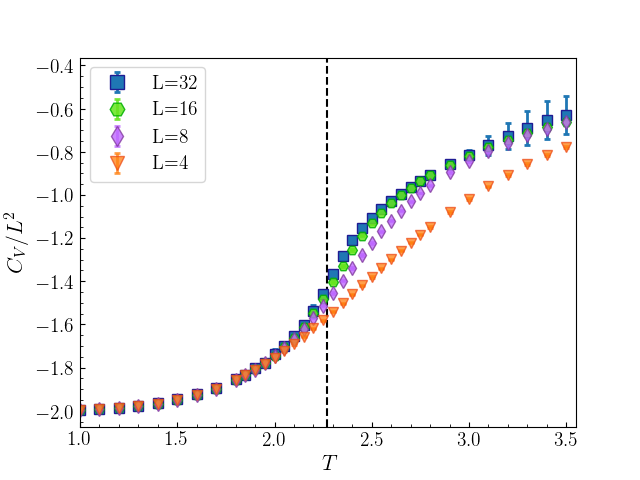

In [643]:
fig, ax = plt.subplots()
ax.errorbar(specific_heat32._energy_temps, specific_heat32._avg_energy,
            yerr=specific_heat32._energy_error,
            marker='s', color='C0',
            markersize=7,  markeredgecolor='#1f1b93',
            ls='', fillstyle='full', lw=1.,
            elinewidth=2.,  alpha=1.0,
            capsize=2, capthick=2,
            label='L=32')
            
ax.errorbar(specific_heat16._energy_temps, specific_heat16._avg_energy,
            yerr=specific_heat16._energy_error,
            marker='H', color='#65e41d',
            markeredgecolor='#00B000', markersize=7., 
            lw=1., elinewidth=2.,  alpha=0.85, ls='',
            fillstyle='full', capsize=2, capthick=2, 
            label='L=16')

ax.errorbar(specific_heat8._energy_temps, specific_heat8._avg_energy,
            yerr=specific_heat8._energy_error,
            marker='d', fillstyle='full', color='#be67ff',
            markeredgecolor='#833c9f', markersize=7, 
            lw=1., elinewidth=2.,  alpha=0.8, ls='',
            capsize=2, capthick=2, 
            label='L=8')

ax.axvline(x=Tc, linestyle='--', color='k')#, label='$T = T_c$')
ax.errorbar(specific_heat4._energy_temps, specific_heat4._avg_energy,
            yerr=specific_heat4._energy_error,
            color='C1', markeredgecolor='#ed4c18', marker='v', 
            fillstyle='full', markersize=7,  lw=2., elinewidth=2., 
            alpha=0.75, capsize=2, capthick=2,  ls='',
            label='L=4')

ax.legend(loc='best', markerscale=1.5, fontsize=14)#, frameon=False)
ax.set_xlim(1., 3.55)
ax.set_xlabel('$T$', fontsize=16)
ax.set_ylabel('$C_V/L^2$', fontsize=16)
#plt.savefig('plots/specific_heat_all.png', dpi=600, bbox_inches='tight')
plt.show()

plt.show()

## Specific Heat

<IPython.core.display.Javascript object>


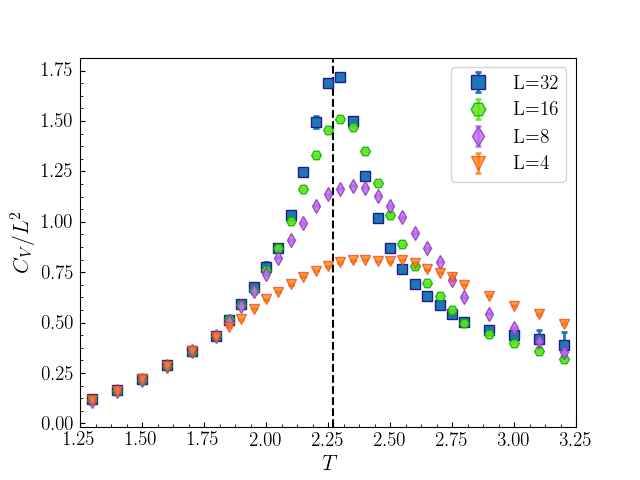

In [645]:
fig, ax = plt.subplots()

ax.axvline(x=Tc, linestyle='--', color='k')#, label='$T = T_c$')
ax.errorbar(specific_heat32._spec_heat_temps, specific_heat32._spec_heat,
            yerr=specific_heat32._spec_heat_err,
            marker='s', color='C0',
            markersize=7,  markeredgecolor='#1f1b93',
            ls='', fillstyle='full', lw=2.,
            elinewidth=2., capsize=2., capthick=2.,
            alpha=1.0, label='L=32')
            
#ax.plot(specific_heat16._specific_heat_temps, specific_heat16._specific_heat,
ax.errorbar(specific_heat16._spec_heat_temps, specific_heat16._spec_heat,
            yerr=specific_heat16._spec_heat_err,
            marker='H', color='#65e41d',
            markeredgecolor='#00B000', markersize=7., 
            lw=2., alpha=0.85, ls='',
            elinewidth=2., capsize=2., capthick=2.,
            fillstyle='full', label='L=16')

#ax.plot(specific_heat8._specific_heat_temps, specific_heat8._specific_heat,
ax.errorbar(specific_heat8._spec_heat_temps, specific_heat8._spec_heat,
            yerr=specific_heat8._spec_heat_err,
            marker='d', fillstyle='full', color='#be67ff',
            markeredgecolor='#833c9f', markersize=7, 
            elinewidth=2., capsize=2., capthick=2.,
            lw=2., alpha=0.8, ls='', label='L=8')

#ax.plot(specific_heat4._specific_heat_temps, specific_heat4._specific_heat,
ax.errorbar(specific_heat4._spec_heat_temps, specific_heat4._spec_heat,
            yerr=specific_heat4._spec_heat_err,
            color='C1', markeredgecolor='#ed4c18', marker='v', 
            fillstyle='full', markersize=7,  lw=2.5, 
            elinewidth=2., capsize=2., capthick=2.,
            alpha=0.75, ls='', label='L=4')

ax.legend(loc='best', markerscale=1.5, fontsize=14)#, frameon=False)
ax.set_xlim(1.25, 3.25)
ax.set_xlabel('$T$', fontsize=16)
ax.set_ylabel('$C_V/L^2$', fontsize=16)
#plt.savefig('plots/specific_heat_all.png', dpi=600, bbox_inches='tight')
plt.show()

plt.show()

## $\langle \Delta_{N_b}^2\rangle$

<IPython.core.display.Javascript object>


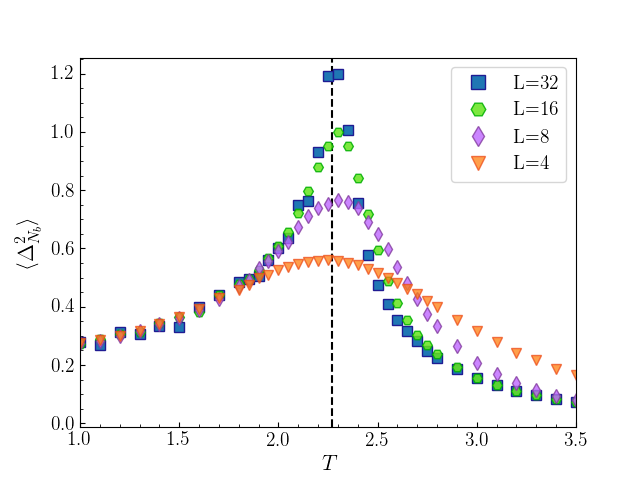

In [648]:
fig, ax = plt.subplots()

ax.axvline(x=Tc, linestyle='--', color='k')#, label='$T = T_c$')
ax.plot(temps32, flucts32/(2*32*32),
        marker='s', color='C0',
        markersize=7,  markeredgecolor='#1f1b93',
        ls='', fillstyle='full', lw=2,
        alpha=1.0,
        label='L=32')
            
ax.plot(temps16, flucts16/(2*16*16),
        marker='H', color='#65e41d',
        markeredgecolor='#00B000', markersize=7., 
        lw=2, alpha=0.85, ls='',
        fillstyle='full',
        label='L=16')

ax.plot(temps8, flucts8/(2*8*8),
        marker='d', fillstyle='full', color='#be67ff',
        markeredgecolor='#833c9f', markersize=7, 
        lw=2, alpha=0.8, ls='',
        label='L=8')


ax.plot(temps4, flucts4/(2*4*4),
        color='C1', markeredgecolor='#ed4c18', marker='v', 
        fillstyle='full', markersize=7,  lw=2, 
        alpha=0.75, ls='',
        label='L=4')


ax.legend(loc='best', markerscale=1.5, fontsize=14)#, frameon=False)
ax.set_xlim(1., 3.5)
#ax.grid(True)
ax.set_xlabel('$T$', fontsize=16)
ax.set_ylabel(r"$\langle \Delta_{N_b}^2\rangle$", fontsize=16)
#ax.set_title('Specific Heat Capacity $C_V$ vs. $T$', fontsize=22)
#plt.savefig('plots/specific_heat_all.png', dpi=600, bbox_inches='tight')
plt.show()

## $\langle \Delta_{N_b}^2\rangle$ (blocked)

<IPython.core.display.Javascript object>


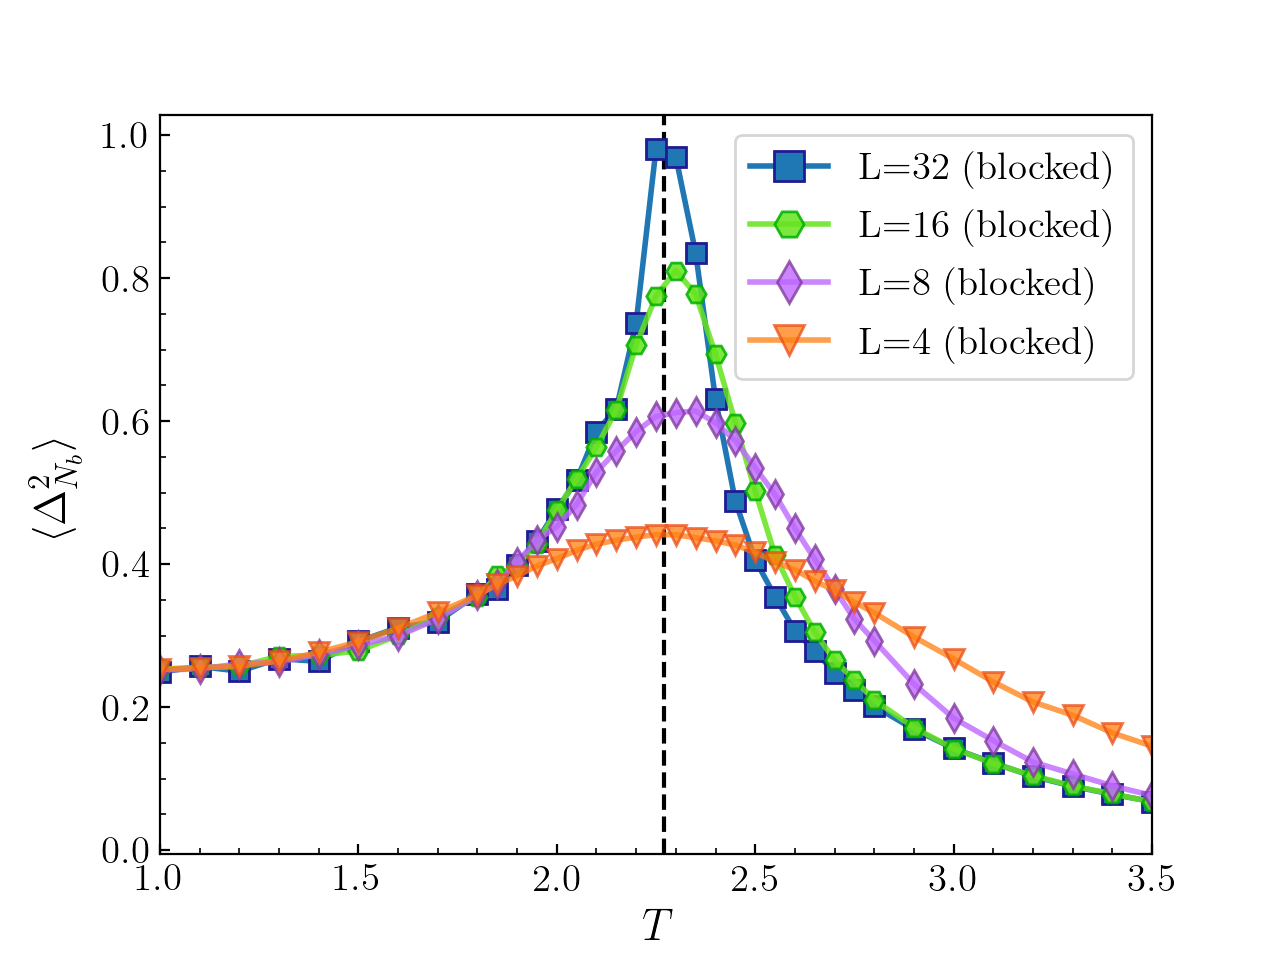

In [604]:
fig, ax = plt.subplots()

ax.axvline(x=Tc, linestyle='--', color='k')#, label='$T = T_c$')
ax.plot(temps32_b, flucts32_b/(2*16*16),
        marker='s', color='C0',
        markersize=7,  markeredgecolor='#1f1b93',
        ls='-', fillstyle='full', lw=2,
        alpha=1.0,
        label='L=32 (blocked)')
            
ax.plot(temps16_b, flucts16_b/(2*8*8),
        marker='H', color='#65e41d',
        markeredgecolor='#00B000', markersize=7., 
        lw=2, alpha=0.85, ls='-',
        fillstyle='full',
        label='L=16 (blocked)')

ax.plot(temps8_b, flucts8_b/(2*4*4),
        marker='d', fillstyle='full', color='#be67ff',
        markeredgecolor='#833c9f', markersize=7, 
        lw=2, alpha=0.8, ls='-',
        label='L=8 (blocked)')

ax.plot(temps4_b, flucts4_b/(2*2*2),
        color='C1', markeredgecolor='#ed4c18', marker='v', 
        fillstyle='full', markersize=7,  lw=2, 
        alpha=0.75, ls='-',
        label='L=4 (blocked)')

ax.legend(loc='best', markerscale=1.5, fontsize=14)#, frameon=False)
ax.set_xlim(1., 3.5)
#ax.grid(True)
ax.set_xlabel('$T$', fontsize=16)
ax.set_ylabel(r"$\langle \Delta_{N_b}^2\rangle$", fontsize=16)
#ax.set_title('Specific Heat Capacity $C_V$ vs. $T$', fontsize=22)
#plt.savefig('plots/specific_heat_all.png', dpi=600, bbox_inches='tight')
plt.show()

## $\lambda_0$

<IPython.core.display.Javascript object>


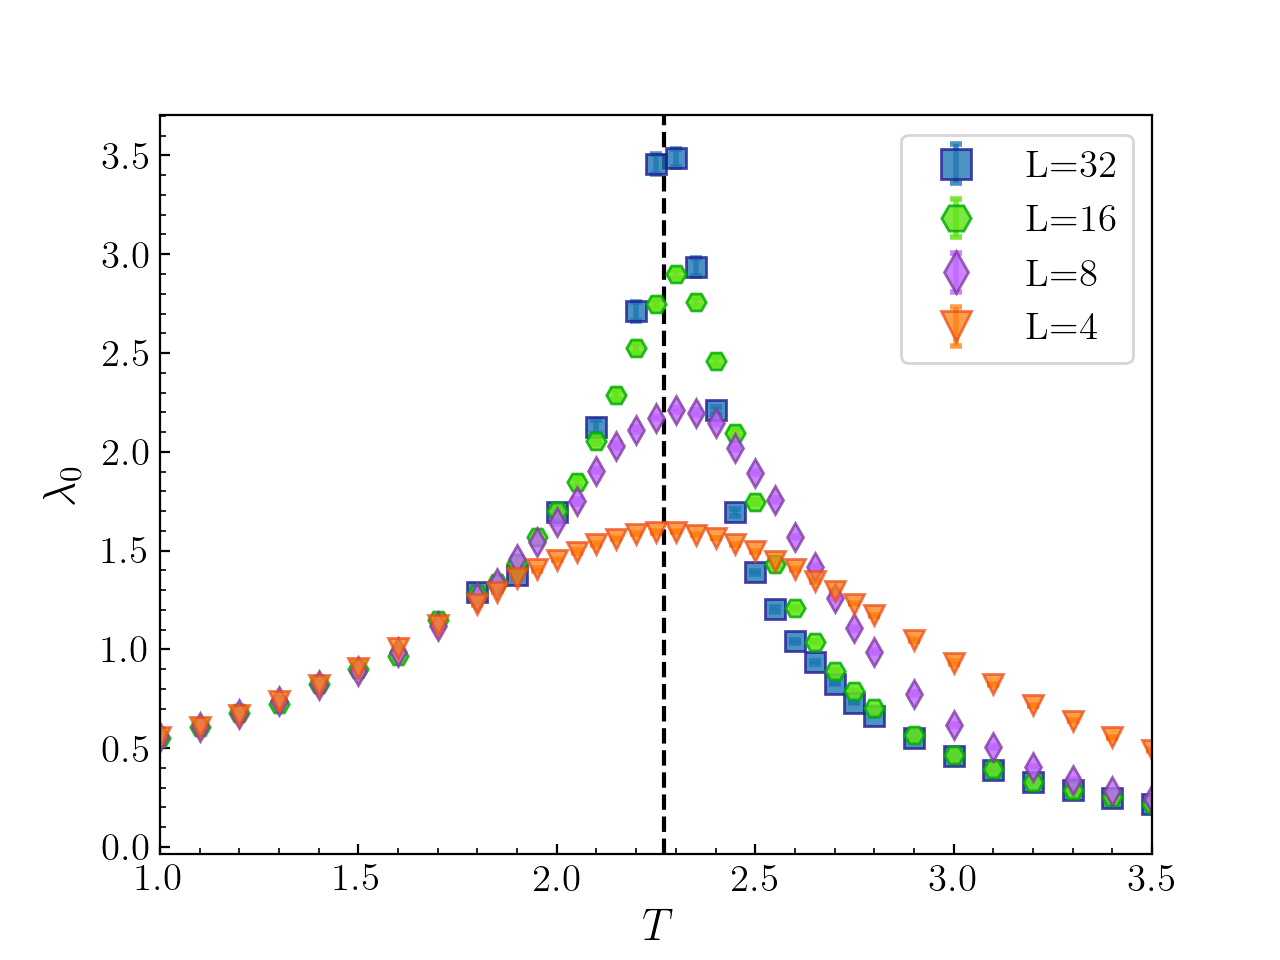

In [605]:
fig, ax = plt.subplots()

ax.axvline(x=Tc, linestyle='--', color='k')#, label='$T = T_c$')

ax.errorbar(pca32._temps, pca32._leading_eig_val_avg,
            yerr=list(pca32._err.values()),
            marker='s', color='C0',
            markersize=7,  markeredgecolor='#1f1b93',
            ls='', fillstyle='full', lw=2.,
            elinewidth=2.,  alpha=1.,
            capsize=2, capthick=2,
            label='L=32')
            
ax.errorbar(pca16._temps, pca16._leading_eig_val_avg,
            yerr=list(pca16._err.values()),
            marker='H', color='#65e41d',
            markeredgecolor='#00B000', markersize=7., 
            lw=2., elinewidth=2.,  alpha=1., ls='',
            fillstyle='full', capsize=2, capthick=2, 
            label='L=16')

ax.errorbar(pca8._temps, pca8._leading_eig_val_avg,
            yerr=list(pca8._err.values()),
            marker='d', fillstyle='full', color='#be67ff',
            markeredgecolor='#833c9f', markersize=7, 
            lw=2., elinewidth=2.,  alpha=1., ls='',
            capsize=2, capthick=2, 
            label='L=8')


ax.errorbar(pca4._temps, pca4._leading_eig_val_avg,
            yerr=list(pca4._err.values()),
            color='C1', markeredgecolor='#ed4c18', marker='v', 
            fillstyle='full', markersize=7,  lw=2., elinewidth=2., 
            alpha=1., capsize=2, capthick=2,  ls='',
            label='L=4')

ax.legend(loc='best', markerscale=1.5, fontsize=14)#, frameon=False)
ax.set_xlim(1., 3.5)
#ax.grid(True)
ax.set_xlabel('$T$', fontsize=16)
ax.set_ylabel('$\lambda_0$', fontsize=16)
#ax.set_title('Specific Heat Capacity $C_V$ vs. $T$', fontsize=22)
#plt.savefig('plots/specific_heat_all.png', dpi=600, bbox_inches='tight')
plt.show()

## $\lambda_0^{blocked}$

<IPython.core.display.Javascript object>


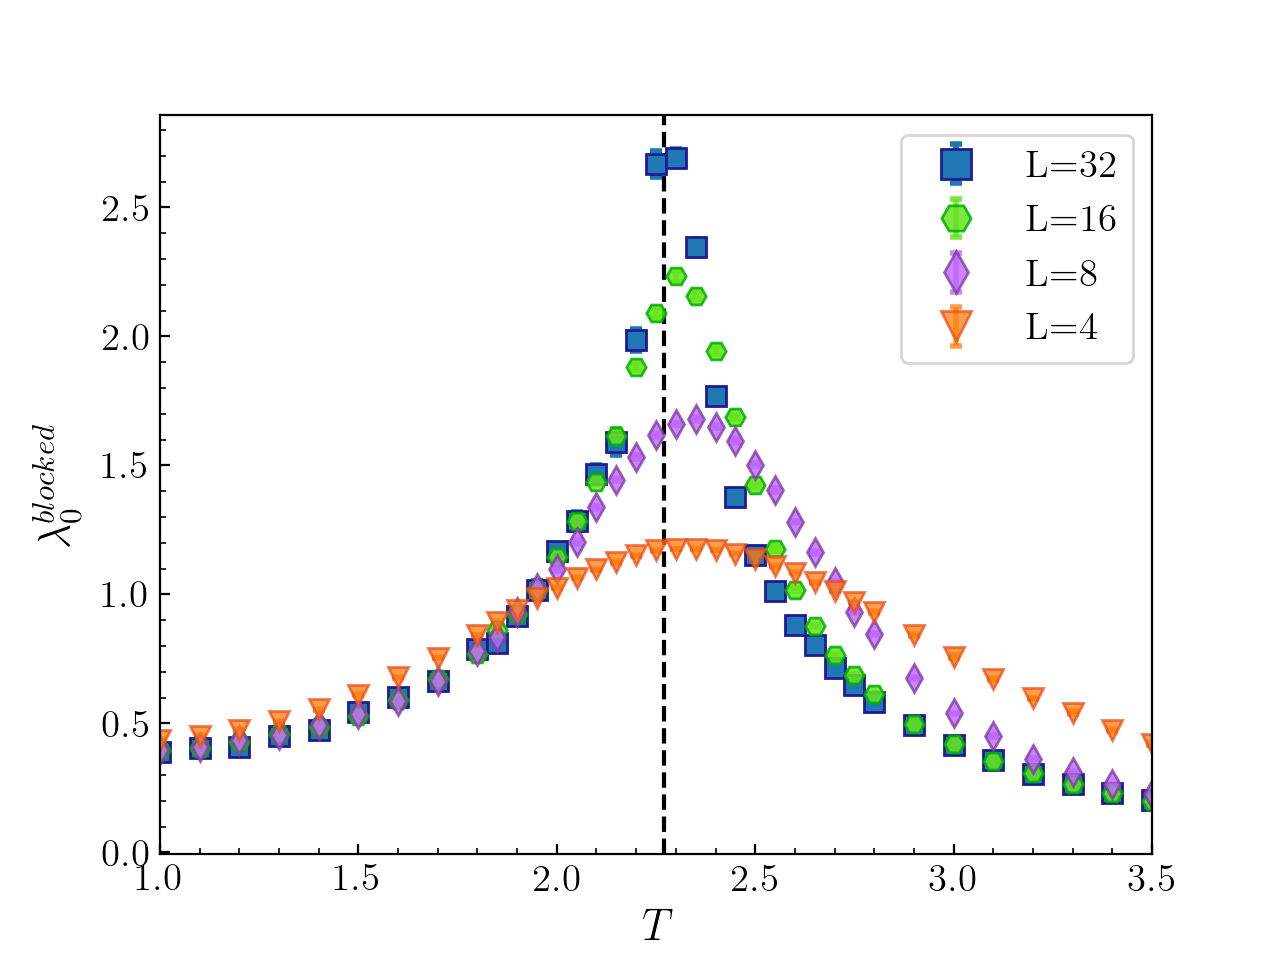

In [606]:
fig, ax = plt.subplots()

ax.axvline(x=Tc, linestyle='--', color='k')#, label='$T = T_c$')

ax.errorbar(pca32_b._temps, pca32_b._leading_eig_val_avg,
            yerr=list(pca32_b._err.values()),
            marker='s', color='C0',
            markersize=7,  markeredgecolor='#1f1b93',
            ls='', fillstyle='full', lw=2.,
            elinewidth=2.,  alpha=1.,
            capsize=2, capthick=2,
            label='L=32')
            
ax.errorbar(pca16_b._temps, pca16_b._leading_eig_val_avg,
            yerr=list(pca16_b._err.values()),
            marker='H', color='#65e41d',
            markeredgecolor='#00B000', markersize=7., 
            lw=2., elinewidth=2.,  alpha=0.85, ls='',
            fillstyle='full', capsize=2, capthick=2, 
            label='L=16')

ax.errorbar(pca8_b._temps, pca8_b._leading_eig_val_avg,
            yerr=list(pca8_b._err.values()),
            marker='d', fillstyle='full', color='#be67ff',
            markeredgecolor='#833c9f', markersize=7, 
            lw=2., elinewidth=2.,  alpha=0.8, ls='',
            capsize=2, capthick=2, 
            label='L=8')


ax.errorbar(pca4_b._temps, pca4_b._leading_eig_val_avg,
            yerr=list(pca4_b._err.values()),
            color='C1', markeredgecolor='#ed4c18', marker='v', 
            fillstyle='full', markersize=7,  lw=2., elinewidth=2., 
            alpha=0.75, capsize=2, capthick=2,  ls='',
            label='L=4')

ax.legend(loc='best', markerscale=1.5, fontsize=14)#, frameon=False)
ax.set_xlim(1., 3.5)
#ax.grid(True)
ax.set_xlabel('$T$', fontsize=16)
ax.set_ylabel('$\lambda_0^{blocked}$', fontsize=16)
#ax.set_title('Specific Heat Capacity $C_V$ vs. $T$', fontsize=22)
#plt.savefig('plots/specific_heat_all.png', dpi=600, bbox_inches='tight')
plt.show()

## Using configs class

In [656]:
from configs import Configs

### L = 4

In [723]:
configs4 = Configs(4)

In [724]:
configs4.analysis()

Reading in from: ../data/configs/4_lattice/separated_data/4_config_1.0.txt

Reading in from: ../data/configs/4_lattice/separated_data/4_config_1.1.txt

Reading in from: ../data/configs/4_lattice/separated_data/4_config_1.2.txt

Reading in from: ../data/configs/4_lattice/separated_data/4_config_1.3.txt

Reading in from: ../data/configs/4_lattice/separated_data/4_config_1.4.txt

Reading in from: ../data/configs/4_lattice/separated_data/4_config_1.5.txt

Reading in from: ../data/configs/4_lattice/separated_data/4_config_1.6.txt

Reading in from: ../data/configs/4_lattice/separated_data/4_config_1.7.txt

Reading in from: ../data/configs/4_lattice/separated_data/4_config_1.8.txt

Reading in from: ../data/configs/4_lattice/separated_data/4_config_1.85.txt

Reading in from: ../data/configs/4_lattice/separated_data/4_config_1.9.txt

Reading in from: ../data/configs/4_lattice/separated_data/4_config_1.95.txt

Reading in from: ../data/configs/4_lattice/separated_data/4_config_2.0.txt

Reading in

NameError: name 'bond_stats' is not defined

In [779]:
pca4 = PrincipalComponent(4)
bc4 = bond_counter(4, write=False)

Reading data from: ../data/configs/4_lattice/separated_data/4_config_1.0.txt
Reading data from: ../data/configs/4_lattice/separated_data/4_config_1.1.txt
Reading data from: ../data/configs/4_lattice/separated_data/4_config_1.2.txt
Reading data from: ../data/configs/4_lattice/separated_data/4_config_1.3.txt
Reading data from: ../data/configs/4_lattice/separated_data/4_config_1.4.txt
Reading data from: ../data/configs/4_lattice/separated_data/4_config_1.5.txt
Reading data from: ../data/configs/4_lattice/separated_data/4_config_1.6.txt
Reading data from: ../data/configs/4_lattice/separated_data/4_config_1.7.txt
Reading data from: ../data/configs/4_lattice/separated_data/4_config_1.8.txt
Reading data from: ../data/configs/4_lattice/separated_data/4_config_1.85.txt
Reading data from: ../data/configs/4_lattice/separated_data/4_config_1.9.txt
Reading data from: ../data/configs/4_lattice/separated_data/4_config_1.95.txt
Reading data from: ../data/configs/4_lattice/separated_data/4_config_2.0.t

In [746]:
Nb4 = np.array([(i[0][0], i[1][0]) for i in list(configs4.bond_stats.values())])

delta_Nb4 = np.array([(i[0][-1], i[1][-1]) for i in list(configs4.bond_stats.values())])

temps4 = [float(i) for i in list(configs4.bond_stats.keys())]

<IPython.core.display.Javascript object>


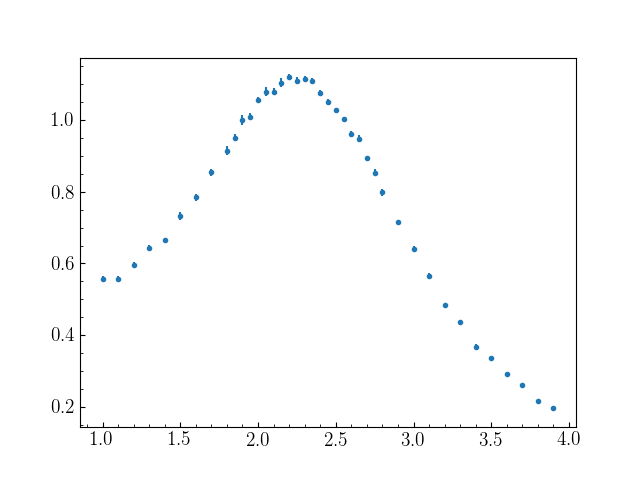

In [762]:
fig, ax = plt.subplots()

ax.errorbar(temps4, delta_Nb4[:,0]/(2*8), yerr=delta_Nb4[:,1]/(2*8), marker='.', ls='')
plt.show()

### L = 8

In [763]:
configs8 = Configs(8)

In [764]:
configs8.analysis()

Reading in from: ../data/configs/8_lattice/separated_data/8_config_1.0.txt

Reading in from: ../data/configs/8_lattice/separated_data/8_config_1.1.txt

Reading in from: ../data/configs/8_lattice/separated_data/8_config_1.2.txt

Reading in from: ../data/configs/8_lattice/separated_data/8_config_1.3.txt

Reading in from: ../data/configs/8_lattice/separated_data/8_config_1.4.txt

Reading in from: ../data/configs/8_lattice/separated_data/8_config_1.5.txt

Reading in from: ../data/configs/8_lattice/separated_data/8_config_1.6.txt

Reading in from: ../data/configs/8_lattice/separated_data/8_config_1.7.txt

Reading in from: ../data/configs/8_lattice/separated_data/8_config_1.8.txt

Reading in from: ../data/configs/8_lattice/separated_data/8_config_1.85.txt

Reading in from: ../data/configs/8_lattice/separated_data/8_config_1.9.txt

Reading in from: ../data/configs/8_lattice/separated_data/8_config_1.95.txt

Reading in from: ../data/configs/8_lattice/separated_data/8_config_2.0.txt

Reading in

In [ ]:
pca8 = PrincipalComponent(8)
bc8 = bond_counter(8, write=True)

In [765]:
Nb8 = np.array([(i[0][0], i[1][0]) for i in list(configs8.bond_stats.values())])
delta_Nb8 = np.array([(i[0][-1], i[1][-1]) for i in list(configs8.bond_stats.values())])
temps8 = [float(i) for i in list(configs8.bond_stats.keys())]

In [771]:
(configs8.leading_eig_vals['1.'][0][0], configs8.leading_eig_vals['1.'][1])

(0.54931666400511425, 0.0054554043371121581)

In [772]:
lambda8 = np.array([(i[0][0], i[1]) for i in list(configs8.leading_eig_vals.values())])
_temps8 = [float(i) for i in list(configs8.leading_eig_vals.keys())]

<IPython.core.display.Javascript object>


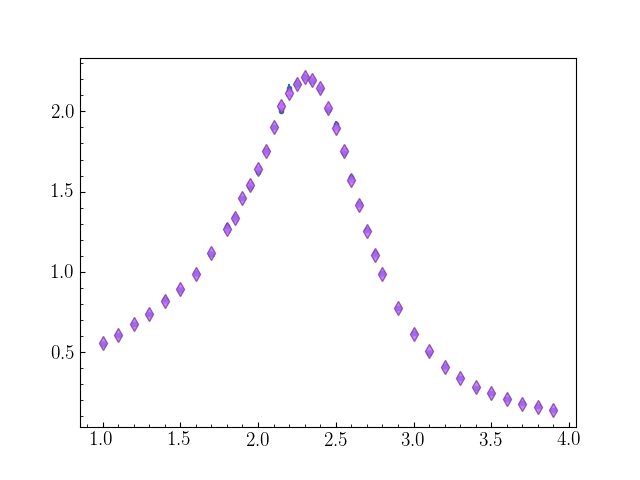

In [775]:
fig, ax = plt.subplots()

ax.errorbar(_temps8, lambda8[:,0], yerr=lambda8[:,1],
            marker='.', ls='')

ax.errorbar(pca8._temps, pca8._leading_eig_val_avg,
            yerr=list(pca8._err.values()),
            marker='d', fillstyle='full', color='#be67ff',
            markeredgecolor='#833c9f', markersize=7, 
            lw=2., elinewidth=2.,  alpha=0.8, ls='',
            capsize=2, capthick=2, 
            label='L=8')
plt.show()

In [776]:
len(_temps8)

40

In [777]:
len(pca8._temps)

40

<IPython.core.display.Javascript object>


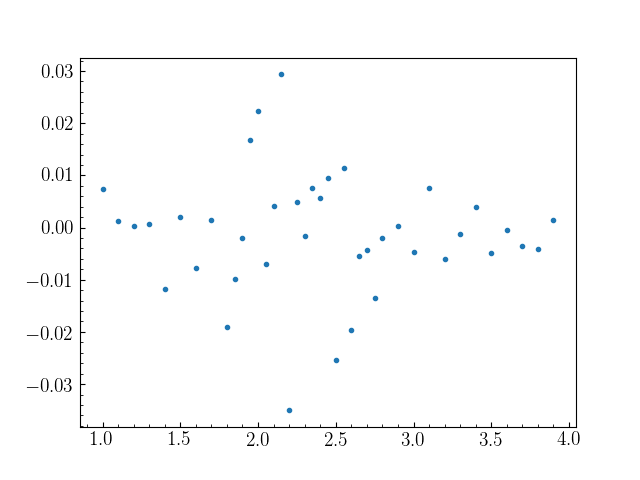

In [778]:
fig, ax = plt.subplots()
ax.plot(_temps8, (pca8._leading_eig_val_avg - lambda8[:,0]), marker='.', ls='')
plt.show()

## OLD

In [658]:
import os

In [659]:
os.getcwd()

'/Users/saforem2/worm_algorithm/worm_algorithm'

In [660]:
data4_dir = '../data/configs/4_lattice/separated_data/'
data4_files = [data4_dir + i for i in os.listdir(data4_dir) if i.endswith('.txt')]

In [666]:
out = os.popen('wc -l {}'.format(data4_files[0])).read()

In [676]:
out4 = [i for i in os.popen('wc -l {}'.format(data4_files)).read()]

In [678]:
out4 = []
for i in data4_files:
    out4.append(os.popen('wc -l {}'.format(i)).read())

In [682]:
out4 = os.popen('wc -l {}/*.txt'.format(data4_dir)).read().split('\n')[:-2]

In [697]:
out4

['  281870 ../data/configs/4_lattice/separated_data//4_config_1.0.txt',
 '  268552 ../data/configs/4_lattice/separated_data//4_config_1.1.txt',
 '  254116 ../data/configs/4_lattice/separated_data//4_config_1.2.txt',
 '  239757 ../data/configs/4_lattice/separated_data//4_config_1.3.txt',
 '  225825 ../data/configs/4_lattice/separated_data//4_config_1.4.txt',
 '  212727 ../data/configs/4_lattice/separated_data//4_config_1.5.txt',
 '  199376 ../data/configs/4_lattice/separated_data//4_config_1.6.txt',
 '  187579 ../data/configs/4_lattice/separated_data//4_config_1.7.txt',
 '  295540 ../data/configs/4_lattice/separated_data//4_config_1.8.txt',
 '  123817 ../data/configs/4_lattice/separated_data//4_config_1.85.txt',
 '  288386 ../data/configs/4_lattice/separated_data//4_config_1.9.txt',
 '  127620 ../data/configs/4_lattice/separated_data//4_config_1.95.txt',
 '  456272 ../data/configs/4_lattice/separated_data//4_config_2.0.txt',
 '  316853 ../data/configs/4_lattice/separated_data//4_config_

In [686]:
(out4[0].split(' ')[2], out4[0].split(' ')[3])

('281870', '../data/configs/4_lattice/separated_data//4_config_1.0.txt')

In [689]:
out4_split = [i.split(' ') for i in out4]

In [718]:
tup4 = []
for i in out4_split:
    tup4.append([float(i[-2]), i[-1]])

[[469446.0, '../data/configs/4_lattice/separated_data//4_config_2.2.txt'],
 [464711.0, '../data/configs/4_lattice/separated_data//4_config_2.1.txt'],
 [456272.0, '../data/configs/4_lattice/separated_data//4_config_2.0.txt'],
 [430620.0, '../data/configs/4_lattice/separated_data//4_config_2.3.txt'],
 [350850.0, '../data/configs/4_lattice/separated_data//4_config_2.25.txt'],
 [331993.0, '../data/configs/4_lattice/separated_data//4_config_2.15.txt'],
 [329132.0, '../data/configs/4_lattice/separated_data//4_config_2.35.txt'],
 [316853.0, '../data/configs/4_lattice/separated_data//4_config_2.05.txt'],
 [312103.0, '../data/configs/4_lattice/separated_data//4_config_2.7.txt'],
 [297343.0, '../data/configs/4_lattice/separated_data//4_config_2.6.txt'],
 [295540.0, '../data/configs/4_lattice/separated_data//4_config_1.8.txt'],
 [288386.0, '../data/configs/4_lattice/separated_data//4_config_1.9.txt'],
 [284016.0, '../data/configs/4_lattice/separated_data//4_config_2.5.txt'],
 [281870.0, '../data/

## Rewritten count_bonds

In [783]:
from count_bonds import CountBonds

## L = 4

In [794]:
count_bonds4 = CountBonds(4, verbose=True)

Reading in from: ../data/configs/4_lattice/separated_data/4_config_2.3.txt

Reading in from: ../data/configs/4_lattice/separated_data/4_config_2.2.txt

Reading in from: ../data/configs/4_lattice/separated_data/4_config_2.0.txt

Reading in from: ../data/configs/4_lattice/separated_data/4_config_2.55.txt

Reading in from: ../data/configs/4_lattice/separated_data/4_config_2.1.txt

Reading in from: ../data/configs/4_lattice/separated_data/4_config_2.5.txt

Reading in from: ../data/configs/4_lattice/separated_data/4_config_2.45.txt

Reading in from: ../data/configs/4_lattice/separated_data/4_config_2.4.txt

Reading in from: ../data/configs/4_lattice/separated_data/4_config_2.6.txt

Reading in from: ../data/configs/4_lattice/separated_data/4_config_2.7.txt

Reading in from: ../data/configs/4_lattice/separated_data/4_config_3.0.txt

Reading in from: ../data/configs/4_lattice/separated_data/4_config_1.2.txt

Reading in from: ../data/configs/4_lattice/separated_data/4_config_1.3.txt

Reading in

In [796]:
Nb4 = np.array([(i[0], i[1]) for i in list(count_bonds4.bond_stats.values())])
delta_Nb4 = np.array([(i[2], i[3]) for i in list(count_bonds4.bond_stats.values())])
Nb4_temps = np.array([float(i) for i in list(count_bonds4.bond_stats.keys())])

## L = 8

In [802]:
count_bonds8 = CountBonds(8, verbose=True)

Reading in from: ../data/configs/8_lattice/separated_data/8_config_3.3.txt

Reading in from: ../data/configs/8_lattice/separated_data/8_config_1.1.txt

Reading in from: ../data/configs/8_lattice/separated_data/8_config_1.0.txt

Reading in from: ../data/configs/8_lattice/separated_data/8_config_2.05.txt

Reading in from: ../data/configs/8_lattice/separated_data/8_config_3.2.txt

Reading in from: ../data/configs/8_lattice/separated_data/8_config_3.0.txt

Reading in from: ../data/configs/8_lattice/separated_data/8_config_1.2.txt

Reading in from: ../data/configs/8_lattice/separated_data/8_config_1.95.txt

Reading in from: ../data/configs/8_lattice/separated_data/8_config_1.3.txt

Reading in from: ../data/configs/8_lattice/separated_data/8_config_3.1.txt

Reading in from: ../data/configs/8_lattice/separated_data/8_config_3.5.txt

Reading in from: ../data/configs/8_lattice/separated_data/8_config_1.7.txt

Reading in from: ../data/configs/8_lattice/separated_data/8_config_1.6.txt

Reading in

In [803]:
Nb8 = np.array([(i[0], i[1]) for i in list(count_bonds8.bond_stats.values())])
delta_Nb8 = np.array([(i[2], i[3]) for i in list(count_bonds8.bond_stats.values())])
Nb8_temps = np.array([float(i) for i in list(count_bonds8.bond_stats.keys())])

## L = 16

In [804]:
count_bonds16 = CountBonds(16, verbose=True)

Reading in from: ../data/configs/16_lattice/separated_data/16_config_2.75.txt

Reading in from: ../data/configs/16_lattice/separated_data/16_config_1.9.txt

Reading in from: ../data/configs/16_lattice/separated_data/16_config_2.65.txt

Reading in from: ../data/configs/16_lattice/separated_data/16_config_1.8.txt

Reading in from: ../data/configs/16_lattice/separated_data/16_config_3.8.txt

Reading in from: ../data/configs/16_lattice/separated_data/16_config_3.9.txt

Reading in from: ../data/configs/16_lattice/separated_data/16_config_2.15.txt

Reading in from: ../data/configs/16_lattice/separated_data/16_config_1.85.txt

Reading in from: ../data/configs/16_lattice/separated_data/16_config_2.8.txt

Reading in from: ../data/configs/16_lattice/separated_data/16_config_1.95.txt

Reading in from: ../data/configs/16_lattice/separated_data/16_config_2.9.txt

Reading in from: ../data/configs/16_lattice/separated_data/16_config_2.05.txt

Reading in from: ../data/configs/16_lattice/separated_data

In [805]:
Nb16 = np.array([(i[0], i[1]) for i in list(count_bonds16.bond_stats.values())])
delta_Nb16 = np.array([(i[2], i[3]) for i in list(count_bonds16.bond_stats.values())])
Nb16_temps = np.array([float(i) for i in list(count_bonds16.bond_stats.keys())])

## L = 32

In [806]:
count_bonds32 = CountBonds(32, verbose=True)

Reading in from: ../data/configs/32_lattice/separated_data/32_config_2.4.txt

Reading in from: ../data/configs/32_lattice/separated_data/32_config_2.5.txt

Reading in from: ../data/configs/32_lattice/separated_data/32_config_2.75.txt

Reading in from: ../data/configs/32_lattice/separated_data/32_config_2.7.txt

Reading in from: ../data/configs/32_lattice/separated_data/32_config_2.6.txt

Reading in from: ../data/configs/32_lattice/separated_data/32_config_2.2.txt

Reading in from: ../data/configs/32_lattice/separated_data/32_config_2.3.txt

Reading in from: ../data/configs/32_lattice/separated_data/32_config_2.65.txt

Reading in from: ../data/configs/32_lattice/separated_data/32_config_2.1.txt

Reading in from: ../data/configs/32_lattice/separated_data/32_config_2.0.txt

Reading in from: ../data/configs/32_lattice/separated_data/32_config_3.7.txt

Reading in from: ../data/configs/32_lattice/separated_data/32_config_1.5.txt

Reading in from: ../data/configs/32_lattice/separated_data/32_

In [807]:
Nb32 = np.array([(i[0], i[1]) for i in list(count_bonds32.bond_stats.values())])
delta_Nb32 = np.array([(i[2], i[3]) for i in list(count_bonds32.bond_stats.values())])
Nb32_temps = np.array([float(i) for i in list(count_bonds32.bond_stats.keys())])

In [819]:
count_bonds32._save_dir = '../data/bond_stats/32_lattice/'
count_bonds16._save_dir = '../data/bond_stats/16_lattice/'
count_bonds8._save_dir = '../data/bond_stats/8_lattice/'
count_bonds4._save_dir = '../data/bond_stats/4_lattice/'

In [815]:
count_bonds32._save_dir

'../data/bond_stats/32_lattice/'

In [808]:
count_bonds32.bond_stats['1.']

[879.57858986550741,
 0.25884806941234023,
 552.05118676298298,
 8.9078142659696748]

In [818]:
count_bonds32._write_bond_stats()

In [820]:
count_bonds16._write_bond_stats()
count_bonds8._write_bond_stats()
count_bonds4._write_bond_stats()

In [817]:
from collections import OrderedDict

In [ ]:
od = OrderedDict(sorted(count_bonds32.bond_stats.items()), key=lambda t: t[]

<IPython.core.display.Javascript object>


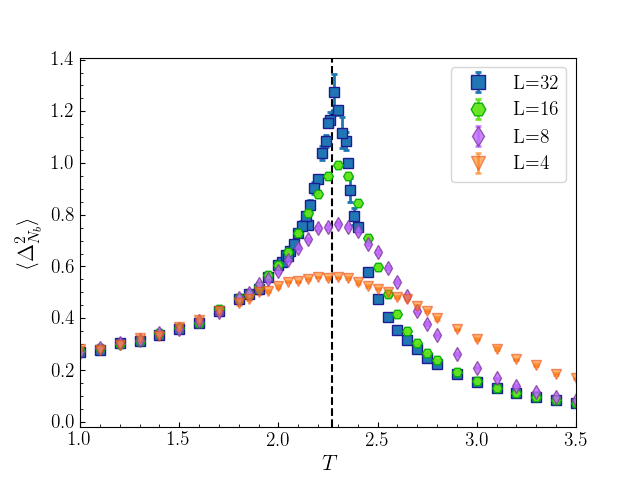

In [828]:
fig, ax = plt.subplots()

ax.axvline(x=Tc, linestyle='--', color='k')#, label='$T = T_c$')
#ax.plot(temps32, flucts32/(2*32*32),
ax.errorbar(Nb32_temps, delta_Nb32[:,0]/(2*32*32), yerr=delta_Nb32[:,1]/(2*32*32),
            marker='s', color='C0', alpha=1.,
            markersize=7,  markeredgecolor='#1f1b93',
            ls='', fillstyle='full', lw=2,
            elinewidth=2.,  capsize=2, capthick=2,
            label='L=32')
            
#ax.plot(temps16, flucts16/(2*16*16),
ax.errorbar(Nb16_temps, delta_Nb16[:,0]/(2*16*16), yerr=delta_Nb16[:,1]/(2*16*16),
            marker='H', color='#65e41d',
            markeredgecolor='#00B000', markersize=7., 
            lw=2, alpha=0.95, ls='', fillstyle='full',
            elinewidth=2.,  capsize=2, capthick=2,
            label='L=16')

#ax.plot(temps8, flucts8/(2*8*8),
ax.errorbar(Nb8_temps, delta_Nb8[:,0]/(2*8*8), yerr=delta_Nb8[:,1]/(2*8*8),
            marker='d', fillstyle='full', color='#be67ff',
            markeredgecolor='#833c9f', markersize=7, 
            lw=2, alpha=0.8, ls='',
            elinewidth=2.,  capsize=2, capthick=2,
            label='L=8')


#ax.plot(temps4, flucts4/(2*4*4),
ax.errorbar(Nb4_temps, delta_Nb4[:,0]/(2*4*4), yerr=delta_Nb4[:,1]/(2*4*4),
            color='C1', markeredgecolor='#ed4c18', marker='v', 
            fillstyle='full', markersize=7,  lw=2, 
            alpha=0.6, ls='',
            elinewidth=2.,  capsize=2, capthick=2,
            label='L=4')


ax.legend(loc='best', markerscale=1.5, fontsize=14)#, frameon=False)
ax.set_xlim(1., 3.5)
#ax.grid(True)
ax.set_xlabel('$T$', fontsize=16)
ax.set_ylabel(r"$\langle \Delta_{N_b}^2\rangle$", fontsize=16)
#ax.set_title('Specific Heat Capacity $C_V$ vs. $T$', fontsize=22)
#plt.savefig('plots/specific_heat_all.png', dpi=600, bbox_inches='tight')
plt.show()

In [856]:
from pca import PrincipalComponent

In [868]:
pca4 = PrincipalComponent(4)

Reading data from: ../data/configs/4_lattice/separated_data/4_config_2.3.txt
Reading data from: ../data/configs/4_lattice/separated_data/4_config_2.2.txt
Reading data from: ../data/configs/4_lattice/separated_data/4_config_2.0.txt
Reading data from: ../data/configs/4_lattice/separated_data/4_config_2.55.txt
Reading data from: ../data/configs/4_lattice/separated_data/4_config_2.1.txt
Reading data from: ../data/configs/4_lattice/separated_data/4_config_2.5.txt
Reading data from: ../data/configs/4_lattice/separated_data/4_config_2.45.txt
Reading data from: ../data/configs/4_lattice/separated_data/4_config_2.4.txt
Reading data from: ../data/configs/4_lattice/separated_data/4_config_2.6.txt
Reading data from: ../data/configs/4_lattice/separated_data/4_config_2.7.txt
Reading data from: ../data/configs/4_lattice/separated_data/4_config_2.34.txt
Reading data from: ../data/configs/4_lattice/separated_data/4_config_2.08.txt
Reading data from: ../data/configs/4_lattice/separated_data/4_config_3.0

In [864]:
pca8 = PrincipalComponent(8)

Reading data from: ../data/configs/8_lattice/separated_data/8_config_3.3.txt
Reading data from: ../data/configs/8_lattice/separated_data/8_config_2.04.txt
Reading data from: ../data/configs/8_lattice/separated_data/8_config_2.38.txt
Reading data from: ../data/configs/8_lattice/separated_data/8_config_1.1.txt
Reading data from: ../data/configs/8_lattice/separated_data/8_config_1.0.txt
Reading data from: ../data/configs/8_lattice/separated_data/8_config_2.05.txt
Reading data from: ../data/configs/8_lattice/separated_data/8_config_3.2.txt
Reading data from: ../data/configs/8_lattice/separated_data/8_config_3.0.txt
Reading data from: ../data/configs/8_lattice/separated_data/8_config_1.2.txt
Reading data from: ../data/configs/8_lattice/separated_data/8_config_1.95.txt
Reading data from: ../data/configs/8_lattice/separated_data/8_config_1.3.txt
Reading data from: ../data/configs/8_lattice/separated_data/8_config_2.06.txt
Reading data from: ../data/configs/8_lattice/separated_data/8_config_2.

In [865]:
pca16 = PrincipalComponent(16)

Reading data from: ../data/configs/16_lattice/separated_data/16_config_2.75.txt
Reading data from: ../data/configs/16_lattice/separated_data/16_config_1.9.txt
Reading data from: ../data/configs/16_lattice/separated_data/16_config_2.65.txt
Reading data from: ../data/configs/16_lattice/separated_data/16_config_1.8.txt
Reading data from: ../data/configs/16_lattice/separated_data/16_config_3.8.txt
Reading data from: ../data/configs/16_lattice/separated_data/16_config_3.9.txt
Reading data from: ../data/configs/16_lattice/separated_data/16_config_2.28.txt
Reading data from: ../data/configs/16_lattice/separated_data/16_config_2.14.txt
Reading data from: ../data/configs/16_lattice/separated_data/16_config_2.15.txt
Reading data from: ../data/configs/16_lattice/separated_data/16_config_1.85.txt
Reading data from: ../data/configs/16_lattice/separated_data/16_config_2.02.txt
Reading data from: ../data/configs/16_lattice/separated_data/16_config_2.16.txt
Reading data from: ../data/configs/16_lattic

In [866]:
pca32 = PrincipalComponent(32)

Reading data from: ../data/configs/32_lattice/separated_data/32_config_2.4.txt
Reading data from: ../data/configs/32_lattice/separated_data/32_config_2.5.txt
Reading data from: ../data/configs/32_lattice/separated_data/32_config_2.75.txt
Reading data from: ../data/configs/32_lattice/separated_data/32_config_2.7.txt
Reading data from: ../data/configs/32_lattice/separated_data/32_config_2.6.txt
Reading data from: ../data/configs/32_lattice/separated_data/32_config_2.2.txt
Reading data from: ../data/configs/32_lattice/separated_data/32_config_2.3.txt
Reading data from: ../data/configs/32_lattice/separated_data/32_config_2.65.txt
Reading data from: ../data/configs/32_lattice/separated_data/32_config_2.1.txt
Reading data from: ../data/configs/32_lattice/separated_data/32_config_2.0.txt
Reading data from: ../data/configs/32_lattice/separated_data/32_config_3.7.txt
Reading data from: ../data/configs/32_lattice/separated_data/32_config_1.5.txt
Reading data from: ../data/configs/32_lattice/sepa

In [873]:
t4 = []
lambda4 = []
lambda4_err = []
for key, val in pca4._eig_vals.items():
    t4.append(float(key))
    lambda4.append(val[0][0])
    lambda4_err.append(pca4._err[key])

In [876]:
pca4_temps = [float(i) for i in list(pca4._eig_vals.keys())]
pca4_vals = [i[0][0] for i in list(pca4._eig_vals.values())]
pca4_err = list(pca4._err.values())

In [877]:
pca8_temps = [float(i) for i in list(pca8._eig_vals.keys())]
pca8_vals = [i[0][0] for i in list(pca8._eig_vals.values())]
pca8_err = list(pca8._err.values())
pca16_temps = [float(i) for i in list(pca16._eig_vals.keys())]
pca16_vals = [i[0][0] for i in list(pca16._eig_vals.values())]
pca16_err = list(pca16._err.values())
pca32_temps = [float(i) for i in list(pca32._eig_vals.keys())]
pca32_vals = [i[0][0] for i in list(pca32._eig_vals.values())]
pca32_err = list(pca32._err.values())

In [887]:
np.array(sorted(Nb32_temps))

array([ 1.  ,  1.1 ,  1.2 ,  1.3 ,  1.4 ,  1.5 ,  1.6 ,  1.7 ,  1.8 ,
        1.85,  1.9 ,  1.95,  2.  ,  2.02,  2.04,  2.05,  2.06,  2.08,
        2.1 ,  2.12,  2.14,  2.15,  2.16,  2.18,  2.2 ,  2.22,  2.24,
        2.25,  2.26,  2.28,  2.3 ,  2.32,  2.34,  2.35,  2.36,  2.38,
        2.4 ,  2.45,  2.5 ,  2.55,  2.6 ,  2.65,  2.7 ,  2.75,  2.8 ,
        2.9 ,  3.  ,  3.1 ,  3.2 ,  3.3 ,  3.4 ,  3.5 ,  3.6 ,  3.7 ,
        3.8 ,  3.9 ])

In [886]:
np.array(pca32_temps)

array([ 1.  ,  1.1 ,  1.2 ,  1.3 ,  1.4 ,  1.5 ,  1.6 ,  1.7 ,  1.8 ,
        1.9 ,  2.  ,  2.02,  2.04,  2.05,  2.06,  2.08,  2.1 ,  2.12,
        2.14,  2.15,  2.16,  2.18,  2.2 ,  2.22,  2.24,  2.25,  2.26,
        2.3 ,  2.35,  2.4 ,  2.45,  2.5 ,  2.55,  2.6 ,  2.65,  2.7 ,
        2.75,  2.8 ,  2.9 ,  3.  ,  3.1 ,  3.2 ,  3.3 ,  3.4 ,  3.5 ,
        3.6 ,  3.7 ,  3.8 ,  3.9 ])

<IPython.core.display.Javascript object>


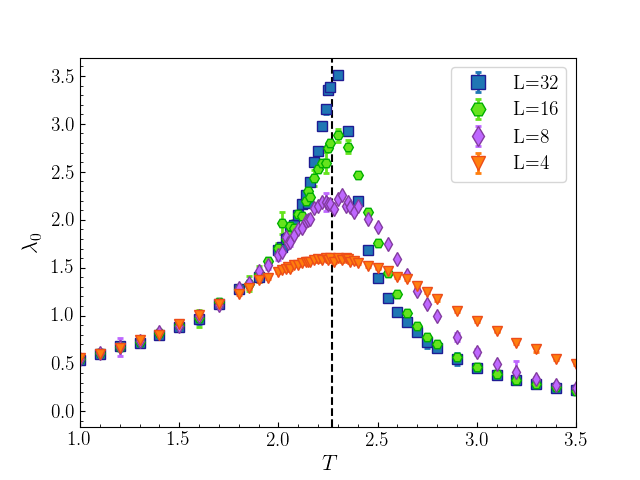

In [878]:
fig, ax = plt.subplots()

ax.axvline(x=Tc, linestyle='--', color='k')#, label='$T = T_c$')

ax.errorbar(pca32_temps, pca32_vals,
            yerr=list(pca32._err.values()),
            marker='s', color='C0',
            markersize=7,  markeredgecolor='#1f1b93',
            ls='', fillstyle='full', lw=2.,
            elinewidth=2.,  alpha=1.,
            capsize=2, capthick=2,
            label='L=32')
            
ax.errorbar(pca16_temps, pca16_vals,
            yerr=list(pca16._err.values()),
            marker='H', color='#65e41d',
            markeredgecolor='#00B000', markersize=7., 
            lw=2., elinewidth=2.,  alpha=1., ls='',
            fillstyle='full', capsize=2, capthick=2, 
            label='L=16')

ax.errorbar(pca8_temps, pca8_vals,
            yerr=list(pca8._err.values()),
            marker='d', fillstyle='full', color='#be67ff',
            markeredgecolor='#833c9f', markersize=7, 
            lw=2., elinewidth=2.,  alpha=1., ls='',
            capsize=2, capthick=2, 
            label='L=8')


ax.errorbar(pca4_temps, pca4_vals,
            yerr=list(pca4._err.values()),
            color='C1', markeredgecolor='#ed4c18', marker='v', 
            fillstyle='full', markersize=7,  lw=2., elinewidth=2., 
            alpha=1., capsize=2, capthick=2,  ls='',
            label='L=4')

ax.legend(loc='best', markerscale=1.5, fontsize=14)#, frameon=False)
ax.set_xlim(1., 3.5)
#ax.grid(True)
ax.set_xlabel('$T$', fontsize=16)
ax.set_ylabel('$\lambda_0$', fontsize=16)
#ax.set_title('Specific Heat Capacity $C_V$ vs. $T$', fontsize=22)
#plt.savefig('plots/specific_heat_all.png', dpi=600, bbox_inches='tight')
plt.show()

In [863]:
with open(pca4._save_dir + 'leading_eigenvalue_{}.txt'.format(4), 'w') as f:
    for key, val in pca4._eig_vals.items():
        f.write("{} {} {}\n".format(key, val[0][0], pca4._err[key]))